<H1 style="text-align: center">SVM Tutorial</H1>

The aim of this notebook is to explore how the Support Vector Machine algorithm works for classification problems. I keep these tutorials to act as a reference for myself and to educate others.

Outline:

1. Familiarise ourselves with constrained optimisation and the Lagrangian dual formulation.
1. Code a linear large margin classifier for linearly separable data.
1. Modify this code, which uses a *hard margin* to a soft margin.
1. Finally, use the *kernel trick* to map the data to a high-dimensional feature space, while calculating the necessary inner-products in the original data space.
1. Adapt SVM for multiclass problems
1. Discuss

At each stage we will test using data and create visualizations.

#### Create a new environment using anaconda prompt

I encountered some issues trying to create a stable environment for the notebook. The main problems encountered were due to the scs convex optimization package not linking/detecting mkl/blas/lapack and the grid search sklearn function not parallelizing correctly. Although, it is quite possible that this problem is exclusive to users of Windows 10 64-bit OS like myself.

In the end I came up with this simple install. Simply run the following in anaconda prompt to create a new environment named ML (mac/linux users should write 'source' before 'conda' I think): 

##### conda create -n ML -c conda-forge -c defaults python=3.6.7 ipykernel numpy scipy scikit-learn matplotlib tqdm cvxopt cvxpy

'-c conda-forge -c defaults' specifies the priorities, descending from left to right, of the channels from which each package should be downloaded.

The new environment must be activated with:

##### conda activate ML

To make the new environment avaialable in Jupyter lab/notebooks:

##### python -m ipykernel install --user --name ML --display-name ML

You should now have the following environment:

In [1]:
print(__import__('sys').version)
!conda list -n ML

3.6.7 (default, Dec  6 2019, 07:03:06) [MSC v.1900 64 bit (AMD64)]
# packages in environment at C:\Anaconda3\envs\ML:
#
# Name                    Version                   Build  Channel
backcall                  0.1.0                      py_0    conda-forge
blas                      1.0                         mkl  
ca-certificates           2019.11.28           hecc5488_0    conda-forge
certifi                   2019.11.28               py36_0    conda-forge
colorama                  0.4.3                      py_0    conda-forge
cvxopt                    1.2.0            py36hdc3235a_0  
cvxpy                     1.0.25           py36h6538335_2    conda-forge
cvxpy-base                1.0.25           py36h6538335_2    conda-forge
cycler                    0.10.0                     py_2    conda-forge
decorator                 4.4.1                      py_0    conda-forge
dill                      0.3.1.1                  py36_0    conda-forge
ecos                      2.0.7     

In [2]:
# import numpy, scipy and matplotlib (pylab) and specify figures to appear inside the notebook (inline).
%pylab inline

# The images saved in the notebook will be in png format but, when you run a cell and generate new output,
# new images will be in svg. svg stands for Scalable Vector Graphics. Basically, like pdfs, the figures we produce
# should look detailed no matter how far we zoom in or out. 
%config InlineBackend.figure_format = 'svg'

# tqdm is useful for making simple progress bars which work in Jupyter notebooks
from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib


## Constrained optimisation with equality constraints

To begin with we will solve an optimisation problem with equality constraints.  The problem is defined for a two-dimensional $\mathbf{x} = (x_1, x_2)^T$ as follows:
$$
\begin{align*}
    \min\limits_\mathbf{x} f(\mathbf{x}) &= \frac{x_1^2}{2}+ x_2^2 \\
    \text{such that}\qquad & x_1 + x_2 = 1
\end{align*}
$$

Basically, we want smallest $x_1$ and $x_2$ possible (ideally 0.0 and 0.0) but we are constrained to points on the line $x_1$ + $x_2$ = 1.

To see what is going on, we will make a contour plot of $f(\mathbf{x})$ and draw the constraint line on it.

You should be able to approximately read the value and location of the constrained minimum from the plot.

In [3]:
def f(x, y):
    '''
    Evaluate the unconstrained objective function
    '''
    return x ** 2 / 2 + y ** 2

def h(x, y):
    '''
    Return x and y that satisfy x + y = 1
    '''
    idx = x + y == 1
    return x[idx], y[idx]

In [4]:
X = linspace(-1, 2, 30), linspace(-1, 2, 30)
X = meshgrid(*X)
fX = f(*X)
hX = h(*X)

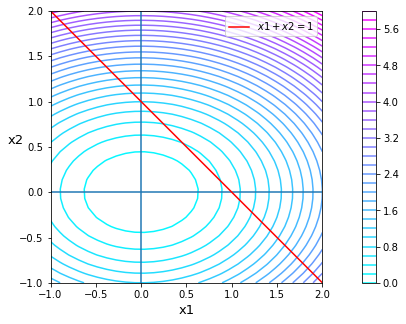

In [5]:
cmap=cm.cool

figsize(7, 5)
axhline(0.0), axvline(0.0)
contour(*X, fX, 30, cmap=cmap)
colorbar()
plot(*hX, c='r', label='$x1 + x2 = 1$')
xlabel('x1', fontsize=13); ylabel('x2', rotation=0, fontsize=13)
#scatter(0, 0, 0, c='k', label='$0.0, 0.0$')
legend()
axis('scaled')
show()

From the above plot, the constrained optimum looks roughly about 0.6, 0.4'

Note:

If desired, we can set matplotlib to use a GUI backend and output figures in a separate dialog window with '%matplotlib qt'.

%matplotlib inline would then force them to appear in the notebook again.


Runing the below cells should generate a 3D figure.

In [6]:
from mpl_toolkits.mplot3d import axes3d #

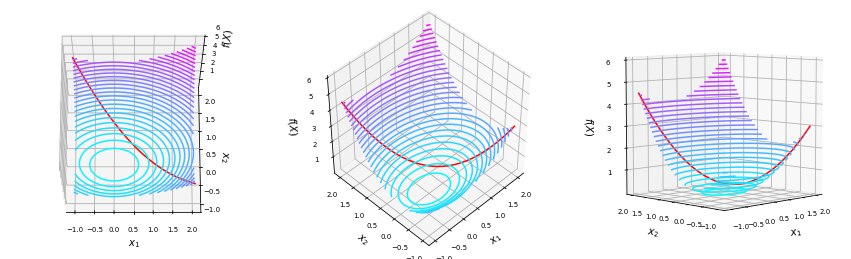

In [7]:
figure(figsize(15, 4.5))
views = [(70, 270), (45, 225), (6, 225)]
for i in range(3):
    subplot(1, 3, i + 1, projection='3d', xlabel='$x_1$', ylabel='$x_2$', zlabel='$f(X)$')
    contour(*X, fX, 30, cmap=cmap, zorder=1)
    plot(*hX, f(*hX), c='r', zorder=2)
    gca().tick_params(axis='both', which='major', labelsize=7)
    gca().view_init(*views[i])

In the 3D representation we can see more clearly that we are trying to get as close to the bottom of the well as possible but are constrained to the red line. From the 2D plot we could see that this point was roughly about 0.6, 0.4.

Below we will write the constraint in standard form $h(\mathbf{x}) = 0$ and therefore write down the Largrangian, $L(\mathbf{x}, \nu)$.

Note: the maths works out a bit smoother if we subtract $v$


### $$     \min\limits_\mathbf{x}f(x) =  \frac{x_1^2}{2} + x_2^2 $$

###     $$ \text{s.t.} \ h_1(x) =  x_1 + x_2 - 1 = 0 $$

### $$ L(\mathbf{x}, v) =  f(x) - \sum_{i=1}^{p} vh_i(x) $$

### $$ L(\mathbf{x}, v) =  \frac{x_1^2}{2} + x_2^2 - v(x_1 + x_2 - 1) $$

First, minimise the unconstrained minimisation problem $L(\mathbf{x}, \nu)$ with respect to $\mathbf{x}$ and $\nu$.  This is done by setting the partial derivatives with respect to $x_1$, $x_2$ and $\nu$ to zero and solving for $x_1$, $x_2$ and $\nu$.


### $ \frac{\delta L}{\delta x_1} = x_1 - v = 0 $

### $ \frac{\delta L}{\delta x_2} = 2x_2 - v = 0 $


### $ \frac{\delta L}{\delta v} = x_1 + x_2 - 1 = 0 $

It can be seen above that:

$ x_1 = v $

and

$ x_2 = \frac{v}{2}$

pluggin these values into the derivative with respect to v yields:

$ v + \frac{v}{2} = 1 $

So

$ v = \frac{2}{3 }$

Going back to equation 1:

$ x_1 -\frac{2}{3} = 0 $

$ x_1 = \frac{2}{3} $

and equation 2:

$ 2x_2 - \frac{2}{3} = 0 $

$ x_2 = \frac{1}{3} $


We can also solve this problem using linear algebra. Wooop woop woop!

In [8]:
         # x1, x2, v
A = array([[1, 0, -1],
           [0, 2, -1],
           [1, 1, 0]])

b = array([[0, 0, 1]]).T

x1, x2, v = inv(A) @ b

print(*('%s = %.3f' % (i, j) for i, j in zip(['x1', 'x2', 'v '], [x1, x2, v])), sep='\n')

x1 = 0.667
x2 = 0.333
v  = 0.667


Plot the minimising point on your contour plot and verify that agrees with  the constraint and the function value at the constrained minimum.

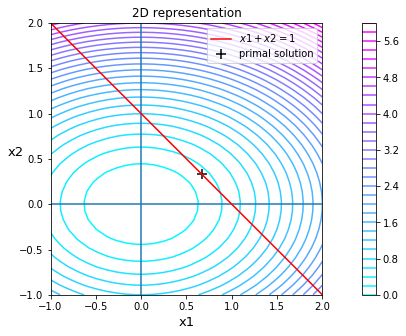

In [9]:
figsize(7, 5)
contour(*X, fX, 30, cmap=cmap)
colorbar()
axhline(0.0)
axvline(0.0)
plot(*hX, c='r', label='$x1 + x2 = 1$')
scatter(x1, x2, marker='+', s=100, c='k', label='primal solution')
xlabel('x1', fontsize=13); ylabel('x2', rotation=0, fontsize=13)
legend()
title('2D representation', fontsize=12)
axis('scaled')
show()

The primal solution obtained seems about right!

For fun, 3d?!

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 18.42it/s]


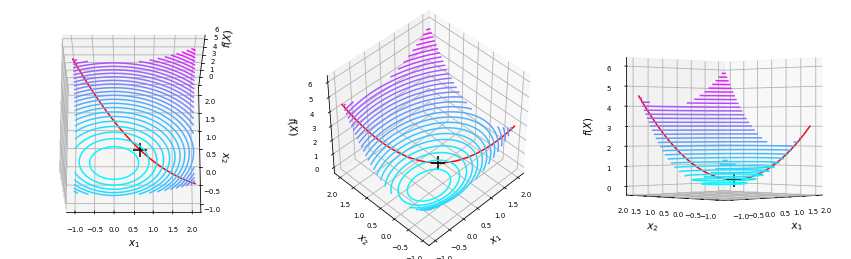

In [10]:
figure(figsize(15, 4.5))
angles = [(70, 270), (45, 225), (0, 225)]
# title('3D representation', fontsize=12)
for i in tqdm(range(3)):
    subplot(1, 3, i + 1, projection='3d', xlabel='$x_1$', ylabel='$x_2$', zlabel='$f(X)$')
    gca().contour(*X, fX, 30, cmap=cmap, zorder=1)
    gca().plot(*hX, f(*hX), c='r', zorder=2)
    gca().scatter(x1, x2, f(x1, x2), marker='+', s=200, c='k', zorder=-1)
    gca().tick_params(axis='both', which='major', labelsize=7)
    gca().view_init(*angles[i])

In [11]:
def L(x, y, v):
    return x ** 2 / 2 + y ** 2 - v * ( x + y - 1)

print('L(x, v) = %.3f' % L(x1, x2, v))

L(x, v) = 0.333


You can just about see the primal solution in the 3D projection. We are very close to the global unconstrained optimum with L(x, v) = 0.333.

Now we will solve the problem again, but this time by finding the Lagrangian dual function, which we will maximise to find the optimal dual variable $\nu$ and thus the optimal $\mathbf{x}$.

By setting the derivative of the Largrangian with respect to $\mathbf{x}$ to zero, find the Largrangian dual function $g(\nu)$.  

Maximise $g(\nu)$ with respect to $\nu$ and so find the optimal dual variable $\nu^\star$ and thus $g(\nu^\star)$.

Use the relations you derived when finding the Lagrangian dual function to get $\mathbf{x}^\star$ from $\nu^\star$.  Thus find $f(\mathbf{x}^\star)$ and verify that it equals $g(\nu^\star)$.


### $ L(\mathbf{x}, v) =  \frac{x_1^2}{2} + x_2^2 - \sum_{n=1}^{p} v(x_1 + x_2 - 1)$

### $ g(v) = \min\limits_\mathbf{x} L(\mathbf{x}, v) $



### $ g(v) = \min\limits_\mathbf{x} \Bigg[ \frac{x_1^2}{2} + x_2^2 - v(x_1 + x_2)\Bigg]$

The dual problem is:

### $ \max\limits_\mathbf{v} g(v) $

from the calculations in the previous cells we can see that L(x, v) is at a minimum when $ x_1 = v $ and $ x_2 = \frac{v}{2} $

so plugging these values into g:

### $ g(v) = \frac{v^2}{2} + (\frac{v}{2})^2 - v(v + \frac{v}{2} - 1) $

### $ \frac{\delta g(v)}{\delta v} = v + \frac{v}{2} - 2v - v + 1 = 0 $

### $ \frac{3}{2}v = 1 $

### $ v^* =  \frac{2}{3} $

so again we yield:

### $x_1^* = \frac{2}{3} $

### $ x_2^* = \frac{1}{3} $

Hence:


### $ g(v^*) = \frac{(\frac{2}{3})}{2}^2 + (\frac{1}{3})^2 - \frac{2}{3}(\frac{2}{3} + \frac{1}{3} - 1) $

### $ = \frac{1}{3}$



In [12]:
def g(v):
    return v ** 2 / 2 + (v / 2) ** 2 - v * (v + v / 2 - 1)

v = 2 / 3
x1 = 2 / 3
x2 = 1 / 3

print('g(v*) = %.3f' % g(v))
print('f(x*) = g(v*) = %s' % repr(L(x1, x2, v) == g(v)))

g(v*) = 0.333
f(x*) = g(v*) = True


As the solutions to the primal and dual problems are equal strong duality is shown. 

## Quadratic programming

At the heart of the dual formulation of the large margin classifier (LMC) is the quadratic programme with constraints.  For example, for the hard LMC the dual Lagrange function to be *maximised* is:

\begin{align*}
        \ \ \ \ \ \ \ \ \ \ \ \ \ \ \max\limits_{\alpha}\sum_n \alpha_n - \frac{1}{2} \sum_{n,m} y_n y_m \alpha_n \alpha_m \langle \mathbf{x}_n, \mathbf{x}_m\rangle \\
\end{align*}
\begin{align*}
\text{such that   }\quad & \alpha_n \ge 0,  \quad \sum_n \alpha_n y_n = 0
\end{align*}

## `cvxpy` example

Here is an example of solving a constrained quadratic program (QP) with `cvxpy`. This is largely copied from https://www.cvxpy.org/examples/basic/quadratic_program.html

The standard form for a QP in `cvxpy` notation is:

\begin{align*}
        \min\limits_{x}  \tfrac{1}{2} x^T P x &+ q^T x \\
        \text{such that   }\quad  Gx &\preceq h\\
        Ax & = b
\end{align*}
where $Gx \preceq h$ means that the inequality is taken element-wise for each row of $Gx$ and $h$.

In `cvxpy` the QP is defined by the parameters $P, q, G, h, A$ and $b$.  The matrix $P$ and the vector $q$ must be specified, but the others are optional.   Note that all optimisations must be manipulated to be of this form.  In particular, note that you will want to *maximise* the Lagrangian dual $g(\mathbf{\alpha})$, so you will have to write the maximisation as the minimisation of $-g(\mathbf{\alpha})$.

Here is a simple example:

\begin{align*}
        \min\limits_{x}  \tfrac{1}{2} x^2 + & 3x + 4y\\
        \text{such that   }\quad x, y & \ge 0\\
        x + 3y & \ge 15\\
        2x + 5y & \le 100\\
        3x + 4y & \le 80
\end{align*}


We will evaluate the objective function on a grid covering the range $[-5, 20] \times [-5, 20]$ and so plot contours of the objective function.  We will also plot lines showing the inequalities and so, by eye, estimate the minimum of the objective function. 

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

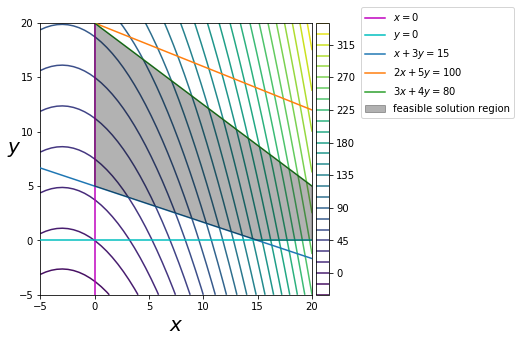

In [14]:
def f(x, y):
    '''Unconstrained objective function'''
    return 0.5 * x ** 2 + 3 * x + 4 * y

'''
The following functions represent the boundaries of the inequality constraints
in the form y = mx + c, they will return the y coordinates for given x
'''
def ineq2(x):
    return -x / 3 + 5

def ineq3(x):
    return -2 / 5 * x + 20

def ineq4(x):
    return -3 / 4 * x + 20

n = 50
cmap = cm.viridis

x = linspace(-5, 20, n)
y = linspace(-5, 20, n)
X, Y = meshgrid(x, y)
fX = f(X, Y)

figure(figsize(7, 5))
contour(X, Y, fX, 30, cmap=cmap, zorder=1)

labels = ['$x = 0$', '$y = 0$', '$x + 3y = 15$', '$2x + 5y = 100$', '$3x + 4y = 80$']
#colors = ['#13CA91', '#FF9472', 'm', 'c', 'r']

# make a list of lists of y values
ineqs = [ineq(x) for ineq in [ineq2, ineq3, ineq4]]

# indices of y values <= 20
idxs = [ys <= 20 for ys in ineqs]

# plot lines constraint boundaries
plot(zeros(y.__len__()), y, label=labels[0], c='m', zorder=2)
plot(x, zeros(x.__len__()), label=labels[1], c='c', zorder=3)
[plot(x[idx], ys[idx], label=l, zorder=z) for ys, idx, l, z in zip(ineqs, idxs, labels[2: ], [4, 5, 6])]

xlabel('$x$', fontsize=20)
ylabel('$y$', fontsize=20, rotation=0)

# feasible solution region coordinates
px, py = array([0, 0, 15, 20, 20]), array([20, 5, 0, 0, 5])

fill(px, py, c='k', label='feasible solution region', alpha=0.3, zorder=7)

legend(loc=(1.18, 0.65))
axis('scaled')

colorbar(cax=make_axes_locatable(gca()).append_axes("right", size="5%", pad=0.05))

show()

It can be seen in the above figure that the optimal value which satisfies the constraints is at the point where the first constraint boundary intersects with x = 0. That is at the point where x + 3y = 15 crosses x = 0, which leads to the x and y values: 0, 5

'eye-balling' where the lines intersect and using some common sense, I have plotted a polygon which represents the region of feasible solutions within the given bounds x, y = -5 to 20.

Sometimes this is just quicker rather than fiddling with some code!

It is also apparent that the constraint $2x + 5y \leq 100$ is satisfied somewhat by the constraint $3x + 4y \leq 80$ and that the former is not incorperated in the boundary of feasible solutions, making it unnecessary.

What about 3d?!

In [15]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.colors as colors

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.78it/s]


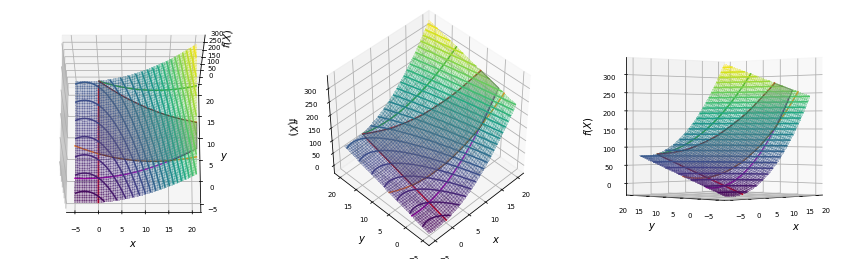

In [16]:
figure(figsize(15, 4.5))

# Viewing angles for subplots
angles = [(70, 270), (45, 225), (0, 225)]

# Surface stuff
res = 5
m   = px.__len__()

polyx = zeros(res * m - 1)
polyy = zeros(res * m - 1)

for i in range(m - 1):
    polyx[res * i: res * i + res] = linspace(px[i], px[i + 1], res)
    polyy[res * i: res * i + res] = linspace(py[i], py[i + 1], res)
    
polyx[-res: ] = linspace(px[-1], px[0], res)
polyy[-res: ] = linspace(py[-1], py[0], res)

polygons = [list(zip(polyx, polyy, f(polyx, polyy)))]

# For plotting x, y = 0
a = zeros(25)
b = arange(-5, 20)

for i in tqdm(range(3)):
    subplot(1, 3, i + 1, projection='3d', xlabel='$x$', ylabel='$y$', zlabel='$f(X)$')
    
    #gca().set_xlim(X.min(), X.max())
    
    # Surface
    gca().plot_surface(X, Y, fX, cmap=cmap,#nipy_spectral,
                   linewidth=0, antialiased=False, alpha=0.3, zorder=1)
    poly = Poly3DCollection(polygons)
    gca().add_collection3d(poly)
    poly.set_color(colors.rgb2hex((0.5, 0.5, 0.5)))
    poly.set_alpha(0.5)
    poly.set_edgecolor('k')
    
    # Contours
    contour(X, Y, fX, 30, zorder=2)
    
    # Lines
    plot(a, b, f(a, b), label='$x = 0$', c='r', zorder=3)
    plot(b, a, f(b, a), label='$x = 0$', c='m', zorder=4)
    [plot(x[idx], ys[idx], f(x[idx], ys[idx]), zorder=z) for ys, idx, z in zip(ineqs, idxs, [5, 6, 7])]
    
    # MPL params
    gca().tick_params(axis='both', which='major', labelsize=7)
    gca().view_init(*angles[i])

The problem can be written in standard form as:

\begin{align*}
  \min\limits_{x, y} \tfrac{1}{2}
  \begin{bmatrix}
    x \\ y
  \end{bmatrix}^T
  \begin{bmatrix}
    1 & 0\\
    0 & 0
  \end{bmatrix}
  \begin{bmatrix}
    x \\ y
  \end{bmatrix}
  +
   \begin{bmatrix}
    3 \\ 4
  \end{bmatrix}^T
 \begin{bmatrix}
    x \\ y
  \end{bmatrix}\\
  \begin{bmatrix}
    -1 & 0\\
    0 & -1\\
    -1 & -3\\
    2 & 5\\
    3 & 4
  \end{bmatrix}
  \begin{bmatrix}
    x \\ y
  \end{bmatrix}  
  \preceq
  \begin{bmatrix}
    0 \\ 0 \\ -15 \\ 100 \\ 80
  \end{bmatrix}
\end{align*}

Note that all the inequality constraints have been gathered into the matrix $G$ and that since there are no equality constraints $A$ and $b$ do not need to be specified.  Note
that even though $y^2$ did not appear in the original objective, we had to include it with zero coefficients in P because the solver parameters must be defined using the full set of variables.  Even if certain variables only appear in constraints, they will still need to be expressed with zero coefficients in the objective parameters, and *vice versa*.

In [17]:
import cvxpy as cp

We specifiy the matrices via `numpy` arrays as follows:

In [18]:
P = diag([1, 0])

q = array([3, 4])

G = array([[-1, 0],
           [0, -1],
           [-1, -3],
           [2, 5],
           [3, 4]])

h = array([0, 
           0,
           -15,
           100,
           80])

# The unknown
x_ = cp.Variable(2,)

# We can write the objective in a high level/abstract way as such:
objective   = cp.Minimize((1 / 2) * cp.quad_form(x_, P) + q.T @ x_)

constraints = [G @ x_ <= h]

problem     = cp.Problem(
                         objective,
                         constraints
                         )

In [19]:
problem.solve(solver='SCS', eps=1e-4)

x_.value

array([3.27825921e-10, 5.00000000e+00])

We can see cvxpy returns, essentially, the same result of 0, 5

You can think of cvxpy as an API for a number of convex solving packages. This means it is possible to change the algorithm that is being used which may yield slightly different results. To see the list of installed solvers you can use the following:

In [20]:
cp.installed_solvers()

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'OSQP', 'SCS']

After testing a few different ones I prefer the SCS solver. 

Anyhow, lets plot our solution...

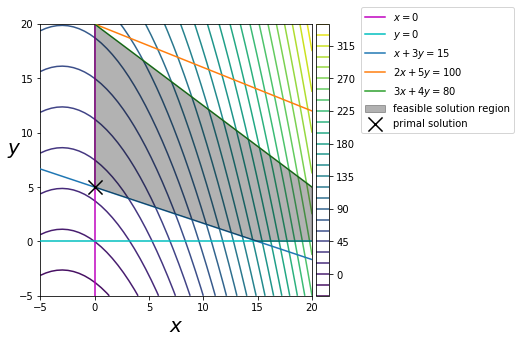

In [21]:
figure(figsize(7, 5))

scatter(*x_.value, marker='x', s=200, c='k', label='primal solution', zorder=8)
contour(X, Y, fX, 30, cmap=cmap, zorder=1)

labels = ['$x = 0$', '$y = 0$', '$x + 3y = 15$', '$2x + 5y = 100$', '$3x + 4y = 80$']
#colors = ['#13CA91', '#FF9472', 'm', 'c', 'r']

# make a list of lists of y values
ineqs = [ineq(x) for ineq in [ineq2, ineq3, ineq4]]

# indices of y values <= 20
idxs = [ys <= 20 for ys in ineqs]

# plot lines constraint boundaries
plot(zeros(n), y, label=labels[0], c='m', zorder=2)
plot(x, zeros(n), label=labels[1], c='c', zorder=3)
[plot(x[idx], ys[idx], label=l, zorder=z) for ys, idx, l, z in zip(ineqs, idxs, labels[2: ], [4, 5, 6])]

xlabel('$x$', fontsize=20)
ylabel('$y$', fontsize=20, rotation=0)

# feasible solution region coordinates
px, py = array([0, 0, 15, 20, 20]), array([20, 5, 0, 0, 5])

fill(px, py, c='k', label='feasible solution region', alpha=0.3, zorder=7)

legend(loc=(1.18, 0.60))
axis('scaled')

colorbar(cax=make_axes_locatable(gca()).append_axes("right", size="5%", pad=0.05))

show()

The cvxpy solution is in agreement with my plot.

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.83it/s]


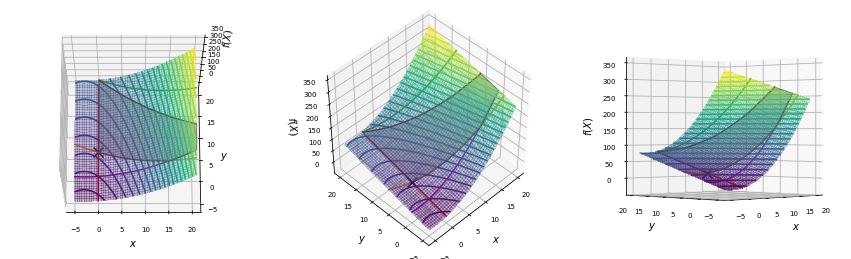

In [22]:
figure(figsize(15, 4.5))

# Viewing angles for subplots
angles = [(70, 270), (45, 225), (0, 225)]

# Surface stuff
res = 5
m   = px.__len__()

polyx = zeros(res * m - 1)
polyy = zeros(res * m - 1)

for i in range(m - 1):
    polyx[res * i: res * i + res] = linspace(px[i], px[i + 1], res)
    polyy[res * i: res * i + res] = linspace(py[i], py[i + 1], res)
    
polyx[-res: ] = linspace(px[-1], px[0], res)
polyy[-res: ] = linspace(py[-1], py[0], res)

polygons = [list(zip(polyx, polyy, f(polyx, polyy)))]

# For plotting x, y = 0
a = zeros(25)
b = arange(-5, 20)

for i in tqdm(range(3)):
    subplot(1, 3, i + 1, projection='3d', xlabel='$x$', ylabel='$y$', zlabel='$f(X)$')
    
    # Surface
    gca().plot_surface(X, Y, fX, cmap=cmap, linewidth=0, antialiased=False, alpha=0.3, zorder=1)
    poly = Poly3DCollection(polygons)
    gca().add_collection3d(poly)
    poly.set_color(colors.rgb2hex((0.5, 0.5, 0.5)))
    poly.set_alpha(0.5)
    poly.set_edgecolor('k')
    
    # Contours
    contour(X, Y, fX, 30, zorder=2)
    
    # Lines
    plot(a, b, f(a, b), label='$x = 0$', c='r', zorder=3)
    plot(b, a, f(b, a), label='$x = 0$', c='m', zorder=4)
    [plot(x[idx], ys[idx], f(x[idx], ys[idx]), zorder=z) for ys, idx, z in zip(ineqs, idxs, [5, 6, 7])]
    
    # Sactter
    gca().scatter(*x_.value, f(*x_.value), marker='x', s=100, c='k', label='primal solution', zorder=8)
    
    # MPL params
    gca().tick_params(axis='both', which='major', labelsize=7)
    gca().view_init(*angles[i])

# Hard, large margin classifier

We will construct a large margin classifier by solving the Lagrangian dual function for a vector of $\alpha$s:

\begin{align*}
        \ \ \ \ \ \ \ \ \ \ \ \ \ \ \max\limits_{\alpha}\sum_n \alpha_n - \frac{1}{2} \sum_{n,m} y_n y_m \alpha_n \alpha_m \langle \mathbf{x}_n, \mathbf{x}_m\rangle \\
\end{align*}
\begin{align*}
\text{such that   }\quad & \alpha_n \ge 0,  \quad \sum_n \alpha_n y_n = 0
\end{align*}

in the form:

\begin{align*}
        \min\limits_{x}  \tfrac{1}{2} x^T P x &+ q^T x \\
        \text{such that   }\quad  Gx &\preceq h\\
        Ax & = b
\end{align*}

The non-zero $\alpha$ correspond the support vectors.

We will write the classifier as a Python class with a method 'descision function' that will return the 'signed' distance of any sample, given as input, from the hyperplane. The distances calculated in the direction of the positive class be positive distances; and the distances in the direction of the negative class will be negative i.e the signed distance is the distance from the hyperplane, with the sign specifying which side of the hyperplane the point is on.  It is easily calculated from $\mathbf{w}^T \mathbf{x} + b$.  

Note when classifying an observation $\mathbf{x}$ it is best not to calculate the coefficients $\mathbf{w}$ in order to calculate the discriminant function $\mathbf{w}^T \mathbf{x} + b$.  This is because later, when we use a kernel to map to higher dimensional spaces, $\mathbf{w}$ may be very high dimensional (possibly infinite dimensional).  Instead we will calculate the discriminant function from the $\mathbf{x}_n, y_n$ and $\alpha_n$.

To reiterate: we do not explicitly calculate $\mathbf{w}$ but we do explicitly calculate $\mathbf{b}$ with: 

\begin{align*}
b = \frac{1}{N} \sum\limits_{n} \big( \alpha_m y_m k(\mathbf{x}_m , \mathbf{x}_n )\big)
\end{align*}

where `n` and `m` correspond to support vectors and samples respectively.

In [23]:
class HLMC:
    '''
            ###############################################################
            # ------------ A Linear Hard Margin SVM Classifier ---------- #
            ###############################################################

    '''
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        '''
        Args:
        X       - array-like, shape [n_train_samples, n_features], training data
        y       - array-like, shape [n_train_samples], training labels
        
        We do not explicitly calculate w for the discriminant function: wTx + b
        but do calculate b using:
        
        b = \frac{1}{N}\sum\limits_{n} [α_m y_m k(x_m , x_n )]
        
        '''
        n_samples, n_features = X.shape

        # Compute proto kernel/gram matrix
        K = dot(X, X.T)

        P = outer(y, y) * K  # kernel/gram matrix
        q = -ones(n_samples) # negative makes it a minimization problem
        A = y.reshape(1, -1)
        b = 0.0
        x = cp.Variable(n_samples) # alphas

        # Constraints
        G = diag(-ones(n_samples))
        h = 0.0 # zeros(n_samples)

        objective   = cp.Minimize(0.5 * cp.quad_form(x, P) + q.T @ x)
        constraints = [G @ x <= h,
                       A @ x == b]

        problem     = cp.Problem(objective, constraints)
        problem.solve(solver='SCS', eps=1e-14, acceleration_lookback=0)

        self.alphas = x.value

        # Support vectors have non zero lagrange multipliers
        mask = self.alphas > 1e-7 # threshold otherwise we end up with everything being a support vector
        self.alphas = self.alphas[mask]
        self.support_vectors = X[mask]
        self.support_vector_labels = y[mask]

        # calculate bias:
        self.b = 0.
        idx = arange(n_samples)[mask]
        n_alpha = len(self.alphas)

        for i in range(n_alpha):
            self.b += self.support_vector_labels[i]
            self.b -= sum(self.alphas * self.support_vector_labels * K[idx[i], mask])
        self.b /= n_alpha
        
        return self
    
    def decision_function(self, X):
        '''
        Calculates the signed distance (d_m) of sample x_m using equation:
        
        d_{m} = \sum\limits_{n}\alpha_{n} y_{n} k(x_{n}, x_{m}) + b
        
        Args:
        X         - array-like, shape[n_samples, n_features], new data
        
        Returns:
        distances - array-like, shape[n_samples, ]
        
        '''
        n_samples = X.__len__()
        distances = zeros(n_samples)
        
        for i in range(n_samples):
            for a, sv, sv_y in zip(
                                   self.alphas,
                                   self.support_vectors,
                                   self.support_vector_labels, 
                                   ):
                
                distances[i] += a * sv_y * dot(X[i], sv)
        distances += self.b

        return distances
    
    def predict(self, X):
        '''
        Returns the prediction, y_u, calculated from the signed distance d_m
        
        y_{m} = sgn( d_{m} )
        
        Args:
        X           - array-like, shape [n_train_samples, n_features], training data
        
        Returns:
        predictions - array-like, shape[n_samples, ]
        '''
        return sign(self.decision_function(X))

It can be seen we calculate the distances of new samples with:
\begin{align*}
d_{m} = \sum\limits_{n}\alpha_n y_n k(\mathbf{x}_n, \mathbf{x}_m) + b
\end{align*}
We turn a distance into a prediction using the signum function:

$$ y_{m} = sgn( d_{m} ) $$

In [24]:
def get_min_max(X1, X2=None, column=0):
    
    '''
    Just a simple helper function.
    Returns min and max values of one or two matrices,
    slightly rescales values by a factor of 1.2 for graphing
    purposes
    '''
    if X2 is not None:
        X = vstack((X1, X2)) 
    else:
        X = X1
    mmin, mmax = min(X[:, column]), max(X[:, column])
    mmin -= abs(mmin) * 0.2
    mmax += abs(mmax) * 0.2
    
    return mmin, mmax

We will now test the classifier code on some two-dimensional linearly separable data.

We will plot the data, the separating hyperplane and its margins, together with the support vectors.

In [25]:
from sklearn.model_selection import train_test_split
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

In [26]:
def plot_svm_results(X, y, grid, mesh, clf, title_string):
    '''
    Displays a figure of training data, hyperplane, margins and support vectors of an
    instance of an svm model
    
    Args:
        X            - array-like, shape[n_samples, n_features], training data
        y            - array-like, shape[n_samples], training target labels
        mesh         - array-like, the output of meshgrid using the min and max of both x1 and x2
        grid         - array-like, shape[n_test_samples], the euclidean distance of test data
                       points from the hyperplane where the sign specifies which side of the
                       hyper plane the point lies
        clf          - a fitted svm
        title_string - str, title for the figure
    
    '''
    
    def get_pts(f, c):
        n = 11
        finished = False
        while not finished:
            g = f.round(n)
            n -= 1
            idx = g == c
            if sum(idx) > 2 or n < 1:
                break
        return idx
    
    def calculate_surface(grid, idx):
        '''
        Takes 3 points from the grid and calculates a 2D surface
        '''
        pts = grid[idx]
        idx = permutation(range(len(pts)))
        
        p0, p1, p2 = pts[idx][:3]
        x0, y0, z0 = p0
        x1, y1, z1 = p1
        x2, y2, z2 = p2

        ux, uy, uz = u = [x1 - x0, y1 - y0, z1 - z0]
        vx, vy, vz = v = [x2 - x0, y2 - y0, z2 - z0]

        u_cross_v = [uy * vz - uz * vy, uz * vx - ux * vz, ux * vy - uy * vx]

        point  = array(p0)
        normal = array(u_cross_v)

        d = -dot(point, normal)

        xx, yy = meshgrid(*[linspace(*get_min_max(grid, column=i), 20) for i in [0, 1]])

        z = (-normal[0] * xx - normal[1] * yy - d) * 1. / normal[2]
        
        return xx, yy, z
    
    def scatter_samples():
            # plot data points
        neg_o = gca().scatter(*[X[y == -1, i] for i in range(n_dims)], c='b', edgecolors='k', marker='o', alpha=0.7, label='$y = -1$', zorder=1)
        pos_o = gca().scatter(*[X[y == 1, i] for i in range(n_dims)], c='r', edgecolors='k', marker='o', alpha=0.7, label='$y = +1$', zorder=2)

        # plot support vectors
        sv_o = gca().scatter(*clf.support_vectors.T, c='purple', s=75, edgecolors='k', label='$support$ $vectors$', zorder=4)

        return neg_o, pos_o, sv_o

    f = clf.decision_function(grid)
    n_dims = mesh.__len__()

    # plot hyperplane and 1, -1 margins
    if n_dims > 2:
        figure(figsize(16, 5))
        style.use('default')
        subplot(projection='3d', xlabel='$x_1$', ylabel='$x_2$', zlabel='$x_3$')
        anchor = 1.75, 0.8
        angles = [(70, 270), (45, 225), (0, 225)]
        surf_minus = calculate_surface(grid, get_pts(f, -1))
        surf_zero  = calculate_surface(grid, get_pts(f, 0))
        surf_plus  = calculate_surface(grid, get_pts(f, 1))
        
        for i in range(3):
            subplot(1, 3, i + 1, projection='3d')
            # Surface
            gca().plot_surface(*surf_minus, color='c', alpha=0.3)
            gca().plot_surface(*surf_zero, color='k', alpha=0.3)
            gca().plot_surface(*surf_plus, color='orange', alpha=0.3)

            gca().tick_params(axis='both', which='major', labelsize=7)
            gca().view_init(*angles[i])
            neg_o, pos_o, sv_o = scatter_samples()
            if i == 1:
                title(title_string, fontsize=15)
    else:
        style.use('seaborn')
        figure(figsize(7, 7))
        anchor = 1, 1
        f = f.reshape(mesh[0].shape)
        contour(*mesh, f, [-1.0], colors='c', linestyles='solid')
        contour(*mesh, f, [0.0], colors='k')
        contour(*mesh, f,  [1.0], colors='orange')
        neg_o, pos_o, sv_o = scatter_samples()

        xlabel('$x_1$', fontsize=14)
        ylabel('$x_2$', fontsize=14, rotation=0)
        title(title_string, fontsize=15)
        
    neg_line = mlines.Line2D([], [], color='c', linestyle='-', label='$w^Tx + b = -1$')
    hyp_line = mlines.Line2D([], [], color='k', linestyle='-', label='$w^Tx + b = 0$')
    pos_line = mlines.Line2D([], [], color='orange', linestyle='-', label='$w^Tx + b = +1$')

    legend(handles=[pos_o, neg_o, sv_o, hyp_line, pos_line, neg_line], fontsize=16, bbox_to_anchor=anchor)
    
    show()

In [27]:
def make_2d_data(mu1, sigma1, mu2, sigma2, random_state=0, n_samples=180, show_data=False):
    '''
    Generates a simple 2d binary classification datatset
    
    mu    - centroid of a class
    sigma - covariance matrix of a class
    
    '''
    seed(random_state)
    X = array([*multivariate_normal(mu1, sigma1, n_samples), *multivariate_normal(mu2, sigma2, n_samples)])
    y = array([*-ones(n_samples), *ones(n_samples)])
    idx = permutation(range(X.__len__()))
    X, y = X[idx], y[idx]
    if show_data:
        figure(figsize(3, 3))
        style.use('default')
        c0 = X[y==-1]
        c1 = X[y==1]
        gca().scatter(c0[:,0], c0[:,1], c='m')
        gca().scatter(c1[:,0], c1[:,1], c='c')
        title('generated data')
        show()
    return X, y

def make_3d_seperable_data(random_state=0, n_samples=180):
    '''
    Generates a simple 3d binary classification problem, linearly seperable datatset
    
    mu    - centroid of a class
    sigma - covariance matrix of a class
    '''
    seed(random_state)
    mu1 = array([4, 4, 4])
    sigma1 = array([[8, 4, 0],
                    [4, 3, 0],
                    [0, 0, 0.01]])

    mu2 = array([5, 5.2, 5.2])
    sigma2 = array([[20, -.1, 0],
                    [-.1, 0.05, 0],
                    [0, 0, 0.01]])
    X = array([*multivariate_normal(mu1, sigma1, n_samples), *multivariate_normal(mu2, sigma2, n_samples)])
    y = array([*-ones(n_samples), *ones(n_samples)])
    idx = permutation(range(X.__len__()))
    X, y = X[idx], y[idx]
    return X, y

def create_grid(X, res=50, return_mesh=True):
    '''
    Creates a grid to represent the problem domain
    '''
    n_dims  = X.shape[1]
    min_max = array([get_min_max(X, column=i) for i in range(n_dims)])
    mesh    = meshgrid(*(linspace(*mm, res) for mm in min_max))
    grid    = array(mesh).T.reshape(-1, n_dims, order='f')
    return grid, mesh if return_mesh else grid

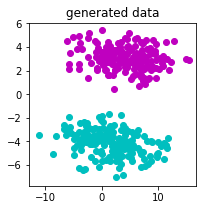

In [28]:
mu1 = array([4, 3])
sigma1 = array([[18, -1],
                [-1, 1]])
mu2 = array([1, -4])
sigma2 = array([[20, -1],
                [-1, 1]])

X, y = make_2d_data(mu1, sigma1, mu2, sigma2, show_data=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We have two linearly seperable blobs!

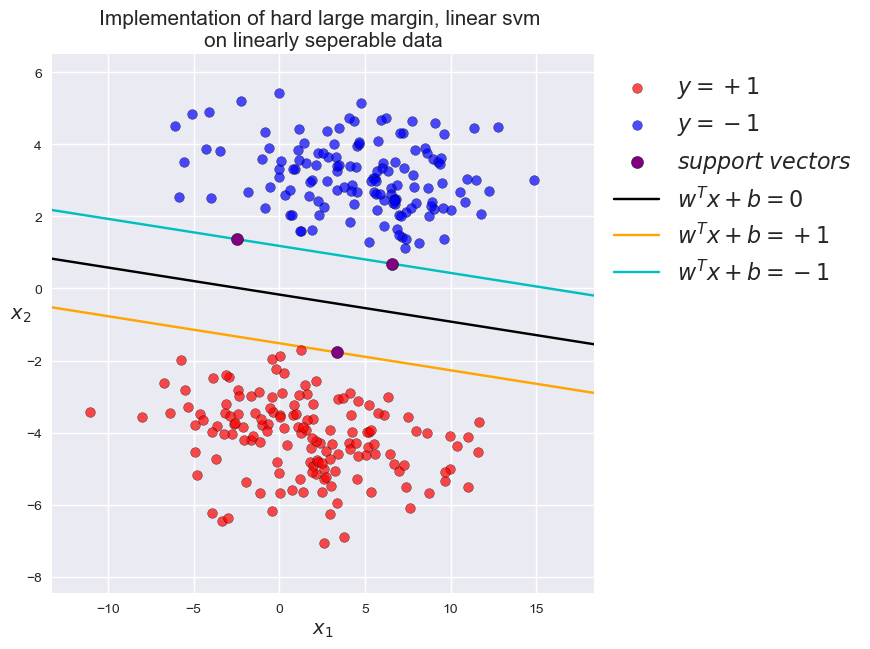

Accuracy =  1.0


In [29]:
# Initialize an instance of the classifier
clf = HLMC()
# Fit it to our data
clf.fit(X_train, y_train)

# Create a grid of pts for plotting margin
grid, mesh = create_grid(X, res=50)

# plot svm
plot_svm_results(X_train, y_train, grid, mesh, clf, 'Implementation of hard large margin, linear svm \non linearly seperable data')
print('Accuracy = ', mean(y_test == clf.predict(X_test)))

We can see in the linearly seperable case the SVM we have coded achieves 100% accuracy. Woop, woop, woop!...

Just for fun, lets take a look at 3 dimensions.

In [30]:
X, y = make_3d_seperable_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

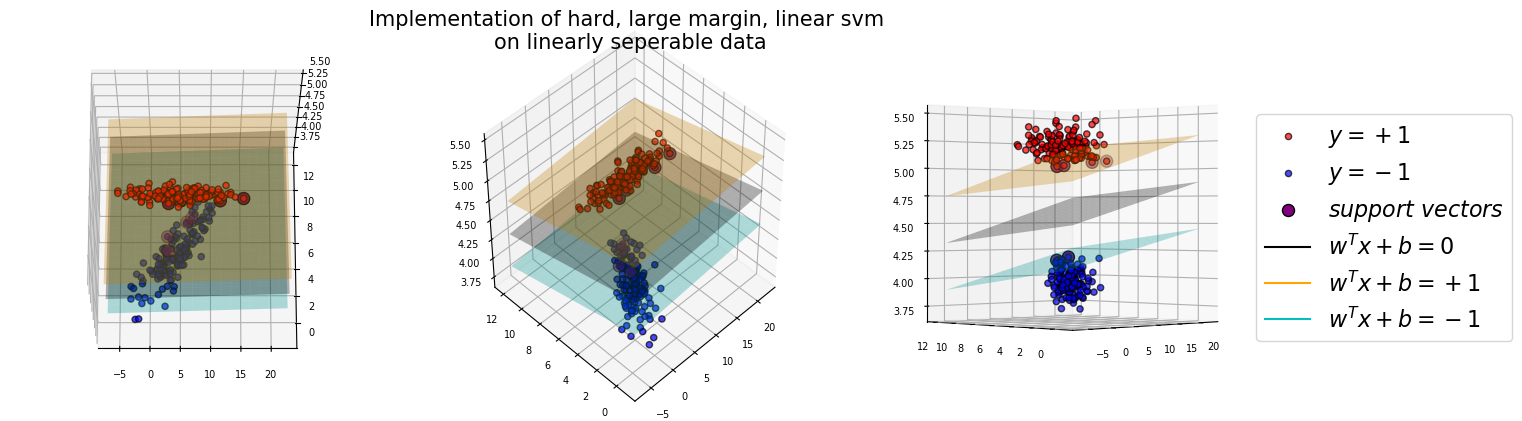

Accuracy =  1.0


In [31]:
clf = HLMC()
clf.fit(X_train, y_train)

# Create a grid of pts for plotting margin
grid, mesh = create_grid(X, res=50)

# plot svm
plot_svm_results(X_train, y_train, grid, mesh, clf, 'Implementation of hard, large margin, linear svm \non linearly seperable data')
print('Accuracy = ', mean(y_test == clf.predict(X_test)))

It can be seen above that the data is linearly seperable.

This simple implementation of an svm manages to separate the data perfectly. Although, this is a relatively easy problem.

What happens if the data are not separable?  Try it.

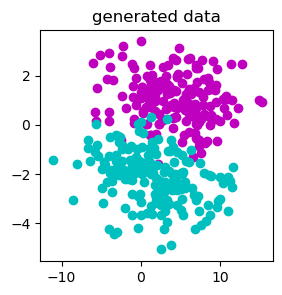

In [32]:
mu1 = array([4, 1])
sigma1 = array([[18, -1],
                [-1, 1]])
mu2 = array([1, -2])
sigma2 = array([[20, -1],
                [-1, 1]])


X, y = make_2d_data(mu1, sigma1, mu2, sigma2, show_data=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
clf = HLMC()

clf.fit(X_train, y_train)

# Create a grid of pts for plotting margin
grid, mesh = create_grid(X, res=50)

# plot svm
plot_svm_results(X_train, y_train, grid, mesh, clf, 'Implementation of hard margin, linear svm \non linearly seperable data')
print('Accuracy = ', mean(y_test == clf.predict(X_test)))

TypeError: '>' not supported between instances of 'NoneType' and 'float'

It can be seen that the classifier simply does not work if the data is not linearly seperable. Basically, the qp solver has not found any alphas that are non-zero above our threshold.

# Soft, large margin classifier

In real life many datasets are not linearly seperable and we must therefore make some alterations to our classifier if it is to work in any situation.

Soft margin classifiers use a parameter `C` to control the degree to which we can allow violation of the margin i.e. to what degree samples can exists on the incorrect side of the margin. Formally, `C` specifies the relative weight given to the emperical error versus the regularisation term. Simply put, higher `C` means harder margin. Lower `C` means softer margin.

All we actually need to change are the constraints:

$$ \begin{align*}
       0 \ge \alpha_n \ge C, \forall n, \quad \sum_n \alpha_n y_n = 0
\end{align*} $$


In [34]:
# You know things are getting real when warnings start getting disabled
# This is basically just to hide some annoying warning messages that are not important
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

Our soft margin classifier will inherit from the hard margin classifier. We won't bother rewriting the prediction or distance function methods as they will be identical.

In [35]:
class SLMC(HLMC):
    
    '''
            ##############################################################
            # ------------ A Soft, Large Margin SVM Classifier --------- #
            ##############################################################

    '''
    def __init__(self, C=0.1):
        
        self.C = float(C)
    
    def fit(self, X, y=None):
        '''
        Args:
        X       - array-like, shape [n_train_samples, n_features], training data
        y       - array-like, shape [n_train_samples], training labels
        
        We do not explicitly calculate w for the discriminant function: wTx + b
        but do calculate b using:
        
        b = \frac{1}{N}\sum\limits_{n} [α_m y_m k(x_m , x_n )]
        
        '''
        n_samples, n_features = X.shape

        # Compute proto kernel/gram matrix
        K = dot(X, X.T)

        P = outer(y, y) * K  # kernel/gram matrix
        q = -ones(n_samples) # negative makes it a minimization problem
        A = y.reshape(1, -1)
        b = 0.0
        x = cp.Variable(n_samples) # alphas

        # Constraints
        # Here's where we make the changes
        G = vstack((-eye(n_samples), eye(n_samples)))
        h = hstack((zeros(n_samples), ones(n_samples) * self.C))

        objective   = cp.Minimize(0.5 * cp.quad_form(x, P) + q.T @ x)
        constraints = [G @ x <= h,
                       A @ x == b]

        problem     = cp.Problem(objective, constraints)
        problem.solve(solver='SCS', eps=1e-14, acceleration_lookback=0)

        self.alphas = x.value

        # Support vectors have non zero lagrange multipliers
        mask = self.alphas > 1e-7 # threshold otherwise we end up with everything being a support vector
        self.alphas = self.alphas[mask]
        self.support_vectors = X[mask]
        self.support_vector_labels = y[mask]

        # Calculate bias:
        self.b = 0
        idx = arange(len(X))[mask]
        n_alpha = len(self.alphas)

        for i in range(n_alpha):
            self.b += self.support_vector_labels[i]
            self.b -= sum(self.alphas * self.support_vector_labels * K[idx[i], mask])
        self.b /= n_alpha

        return self

In [36]:
def std_form(iterable):
    '''
    Converts a list of floats into a list of strings in standard form
    for use on figure axes ticks
    '''
    return ['%.0e' % x for x in iterable]

def base_range(start, end=inf, base=10, n=inf):
    '''
    Creates a range in muliples of 'base'
    '''
    if end is inf and n is inf:
        raise Exception('base_range has no end criteria')
    output = []
    i = 0
    while 1:
        if start > end * base or i == n:
            break
        output.append(start)
        start *= base
        i += 1
    return output

In [37]:
def display_margin_change(X, y, C_range, n_cols=4):
    '''
    A function that will display how the margin changes with different values of C
    
    Args:
        X       - array-like, shape[n_samples, n_features], training data
        y       - array-like, shape[n_samples], training target labels
        C_range - list or array-like, shape[n_experiments], range or C values with which to
                  experiment
        X1, X2  - array-like, the output of meshgrid using the min and max of both x1 and x2
        score   - array-like, shape[n_test_samples], the euclidean distance of test data
                  points from the hyperplane where the sign specifies which side of the
                  hyper plane the point lies
    
    '''
    grid, mesh = create_grid(X)
    n_rows = math.ceil(len(C_range) / n_cols)

    figure(figsize=(12, 11))
    style.use('seaborn')
    for i, C in enumerate(tqdm(C_range)):
        
        clf = SLMC(C=C)
        clf.fit(X_train, y_train)
        z = clf.decision_function(grid)
        z = z.reshape(mesh[0].shape)
        subplot(n_rows, n_cols, i + 1)
        
        tick_params(
                    axis='both',    # changes apply to the x-axis
                    which='both',   # both major and minor ticks are affected
                    bottom=False,   # ticks along the bottom edge are off
                    top=False,
                    left=False,      # ticks along the bottom edge are off
                    right=False,     # ticks along the top edge are off
                    labelbottom=False,
                    labelleft=False,
                    ) 
        
        # plot data points
        neg_o = scatter(X[y == -1, 0], X[y == -1, 1], c='b', s=15, edgecolors='k', alpha=0.7, marker='o', label='$t = -1$')
        pos_o = scatter(X[y == 1, 0], X[y == 1, 1], c='r', s=15, edgecolors='k', alpha=0.7, marker='o', label='$t = +1$')

        # plot support vectors
        sv_o = scatter(*clf.support_vectors.T, c='purple', s=15, edgecolors='k', label='$support$ $vectors$', zorder=4)

        # plot hyperplane and 1, -1 margins
        contour(*mesh, z, [0.0], colors='k')
        contour(*mesh, z, [1.0], colors='orange')
        contour(*mesh, z, [-1.0], colors='c', linestyles='solid')
        
        #subplots_adjust(hspace=0.2, wspace=0.8)
        title('$C = %.0e$' % C)
        
    pos_line = mlines.Line2D([], [], color='orange', linestyle='-', label='$w^Tx + b = +1$')
    neg_line = mlines.Line2D([], [], color='c', linestyle='-', label='$w^Tx + b = -1$')
    hyp_line = mlines.Line2D([], [], color='k', linestyle='-', label='$w^Tx + b = 0$')
        
    legend(
           handles=[pos_o, neg_o, sv_o, hyp_line, pos_line, neg_line], 
           #loc=1, 
           fontsize=16, 
           bbox_to_anchor=(1, 1.1)
           )

    show()

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:36<00:00,  2.41s/it]


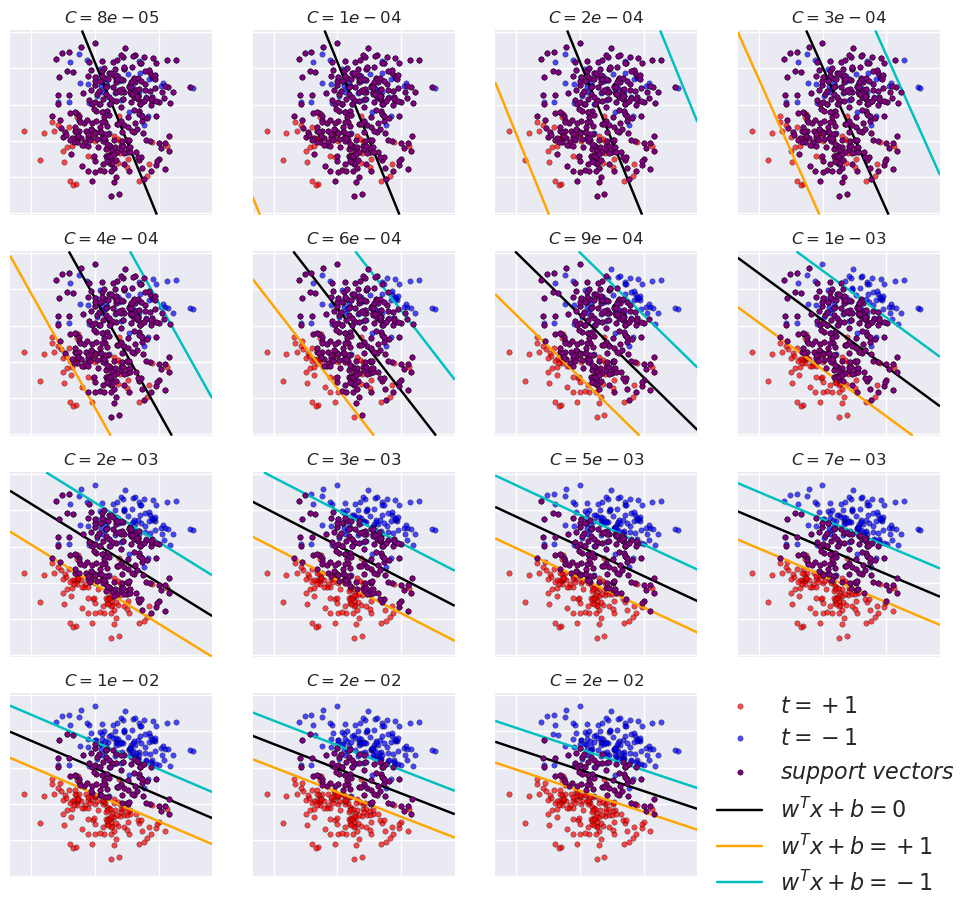

In [38]:
C_range = base_range(8e-5, base=1.5, n=15)

display_margin_change(X, y, C_range)

It can be seen that our classifier can now model linearly inseperable problems. In the figure above we can see that as `C` increases, the margin becomes harder and less violation is allowed.

# Nonlinear SVM

But what if our data looks something like that below?!?

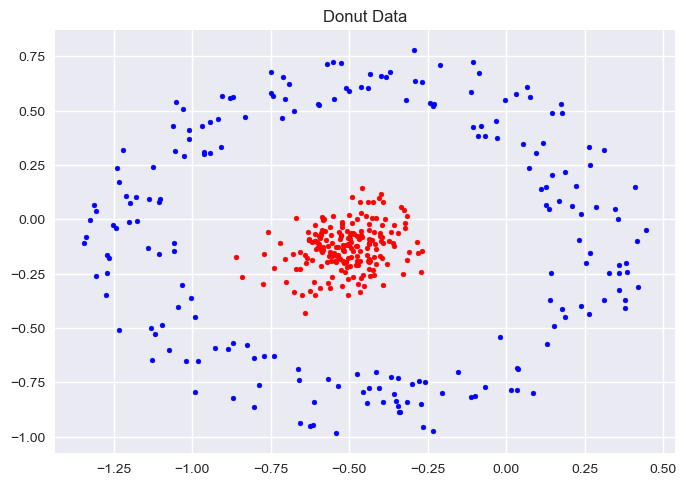

In [39]:
n_samples = 200

rad = 0.6
thk = 0.3
sep = 0.2

c = array([(rad + thk) / 2, sep / 2])

# We use random radius in the interval [rad, rad+thk]
#  and random angles from 0 to pi radians.
r = rand(n_samples) * thk + rad
a = rand(n_samples) * 2 * pi

# In order to plot it we convert it to cartesian:
p = array((r * cos(a), r * sin(a)))

X = array([p[0] - c[0], p[1] - c[1]])

mu    = array([-0.5, -.125])
sigma = array([[0.01, 0.001],
               [0.001, 0.01]])

X = array([*multivariate_normal(mu, sigma, n_samples), *X.T])
y = array([*ones(n_samples), *-ones(n_samples)])

scatter(*X[y==1].T, marker='.', c='r')
scatter(*X[y==-1].T, marker='.', c='b')
title('Donut Data')
show()

There is no single 'best' way the classes can be separated by a straight line.


Below are some kernel functions. Some are non-linear and implicitly map into a higher dimensional space. This allows us to model non linear problems like the one above.

Each kernel function has 2 modes, one with a single array of data points as an argument, and another with 2 arrays of data points.

In [40]:
#from numexpr import evaluate

# Some kernel functions for the svm

def linear_kernel(x, y=None, params={}):
    
    if y is not None:
        output = dot(x, y)
    else:
        output = dot(x, x.T)
        
    return output

def polynomial_kernel(x, y=None, params={}):
    
    delta = params.get('delta', 2.)
    gamma = params.get('gamma', 1.2)
    
    if y is not None:
        output = (gamma + dot(x, y)) ** delta
        
    else:
        output = (gamma + dot(x, x.T)) ** delta
    return output

def rbf_kernel(x, y=None, params={}):
    
    gamma = params.get('gamma', 1.)
    
    if y is not None:
        d = x - y
        output = exp(-gamma * dot(d, d))
    else: 
        x_norm = sum(x ** 2., axis = -1)
        output = exp(-gamma * (x_norm[:,None] + x_norm[None,:] - 2. * dot(x, x.T)))
    return output

def gaussian_kernel(x, y=None, params={}):
    
    gamma = params.get('gamma', 1.)
    
    if y is not None:
        output = exp(-norm(x - y) / (2. * gamma ** 2.))
    else: 
        x_norm = -norm(x[:, None] - x[None, :], axis=2)
        output = exp(x_norm / (2. * gamma ** 2.))
    return output

Here is the complete soft margin SVM classifier (SVC) capable of modeling solutions for non-linear problems. I have written it to conform with the requirements of a custom `estimator` in sklearn. This is basically what a classifier is called in sklearn.

So that we can use the parallelization of sklearn's GridSearchCV function we must import the SVC class from a .py file which I have already prepared. This may just be a requirement of Windows tbh because Python + Windows = bad parallelization. The class in the .py file is essentially the same as below.

In [41]:
# These are required for our estimator to work with some of sklearn's cross validation functions
from sklearn.base import BaseEstimator, ClassifierMixin

class SVC(BaseEstimator, ClassifierMixin):
    ''' 
        
        ######################################################################
        # -A soft margin svm classifier capable of using non-linear kernels- #
        ######################################################################
          
    '''

    def __init__(self, C=None, gamma=1, delta=1, kernel='linear', threshold=1e-7, dtype=float64):
        '''
        Args:
            C         - float or int, the soft margin penalty
            kernel    - function, takes two array-like objects as input and projects them
                        into a different space, returns a single array-like object
            gamma     - float or int, kernel hyperparameter
            delta     - float or int, kernel hyperparameter (polynomial only)
            threshold - float or int, support vectors have alphas that exceed this value
            dtype     - callable or string, the data type to use, effects precision,
                        i.e. np.float32 or 'float64' 

        '''
        
        self.kernel      = kernel
        self.C           = C
        self.gamma       = gamma
        self.delta       = delta
        self.threshold   = threshold
        self.dtype       = dtype
        
    def _init(self):
        
        if self.C:
            self.C = self.dtype(self.C)
        
        if type(self.kernel) == str:
            self.kernel = globals()[self.kernel + '_kernel']
        
    def fit(self, X, y=None):
        ''' 
        Finds the optimal separating hyperplane by solving the dual constraint quadratic
        optimization problem of maximizing the margin by using cvxopt package
        
        Args:
            X - array-like, shape=[n_samples, n_features], the training data
            y - array-like, shape=[n_samples], training targets/labels
                
        '''
        self._init()
        X = X.astype(self.dtype)
        y = y.astype(self.dtype)
        n_samples, n_features = X.shape
    
        # Compute proto kernel/gram matrix
        K = self.kernel(X, params={'gamma': self.gamma, 'delta': self.delta})

        # Build the variables
        P = outer(y, y) * K # kernel/gram matrix
        q = -ones(n_samples, dtype=self.dtype) # negative makes it a minimization problem
        A = y.reshape(1, -1)
        b = self.dtype(0.0)
        x = cp.Variable(n_samples) # alphas
        
        # Constraints
        if self.C:  # If soft margin classifier...
            G = vstack((-eye(n_samples, dtype=self.dtype), eye(n_samples, dtype=self.dtype)))
            h = hstack((zeros(n_samples, dtype=self.dtype), ones(n_samples, dtype=self.dtype) * self.C))
        else:       # Hard margin...
            G = diag(-ones(n_samples, dtype=self.dtype))
            h = self.dtype(0.0) # zeros(n_samples, dtype=self.dtype) # 
            
        objective   = cp.Minimize(0.5 * cp.quad_form(x, P) + q.T @ x)
        constraints = [
                       G @ x <= h, 
                       A @ x == b
                       ]

        problem     = cp.Problem(objective, constraints)
        problem.solve(solver='CVXOPT')#, eps=1e-14)#, acceleration_lookback=0, n_jobs=1)

        self.alphas = x.value

        # Support vectors have non zero lagrange multipliers
        mask = self.alphas > self.threshold # threshold otherwise we end up with everything being a support vector
        self.alphas = self.alphas[mask]
        self.support_vectors = X[mask]
        self.support_vector_labels = y[mask]

        # Calculate bias:
        # .. math::
        # b = \frac{1}{N_S}\sum\limits_{v∈S} [α_u y_u k(x_u , x_v )]

        self.b   = self.dtype(0.0)
        self.idx = arange(len(X))[mask]
        n_alpha  = len(self.alphas)

        for i in range(n_alpha):
            self.b += self.support_vector_labels[i]
            self.b -= sum(self.alphas * self.support_vector_labels * K[self.idx[i], mask])
        self.b /= n_alpha

        return self

    def decision_function(self, X):
        '''
        Calculates the signed distance (d_u) of sample x_u using equation:
        
        d_{m} = \sum\limits_{n}\alpha_{n} y_{n} k(x_{n}, x_{m}) + b
        
        Args:
        X         - array-like, shape[n_samples, n_features], new data
        
        Returns:
        distances - array-like, shape[n_samples, ]
        
        '''
        n_samples = X.__len__()
        distances = zeros(n_samples)
        
        for i in range(n_samples):
            for a, sv, sv_y in zip(
                                   self.alphas,
                                   self.support_vectors,
                                   self.support_vector_labels, 
                                   ):
                
                distances[i] += a * sv_y * dot(X[i], sv)
        distances += self.b

        return distances
    
    def predict(self, X):
        '''
        Returns the prediction, y_u, calculated from the signed distance d_u
        
        y_{m} = sgn( d_{m} )
        
        Args:
        X           - array-like, shape [n_train_samples, n_features], training data
        
        Returns:
        predictions - array-like, shape[n_samples, ]
        '''
        return sign(self.decision_function(X))

Due to what I think is related to the parallel processing of the linear algebra library my version of numpy is using (seems to be cblas), gridsearch will not allow parallelization unless we put our SVM into a ibrary and import it. The below code contains the kernels and SVM as a single string which we will save as a .py and import as a library.

In [40]:
from svm1 import SVC

Below we can see that a non-linear kernel such as an rbf kernel is able to apply a curved hyperplane which can separate the classes.

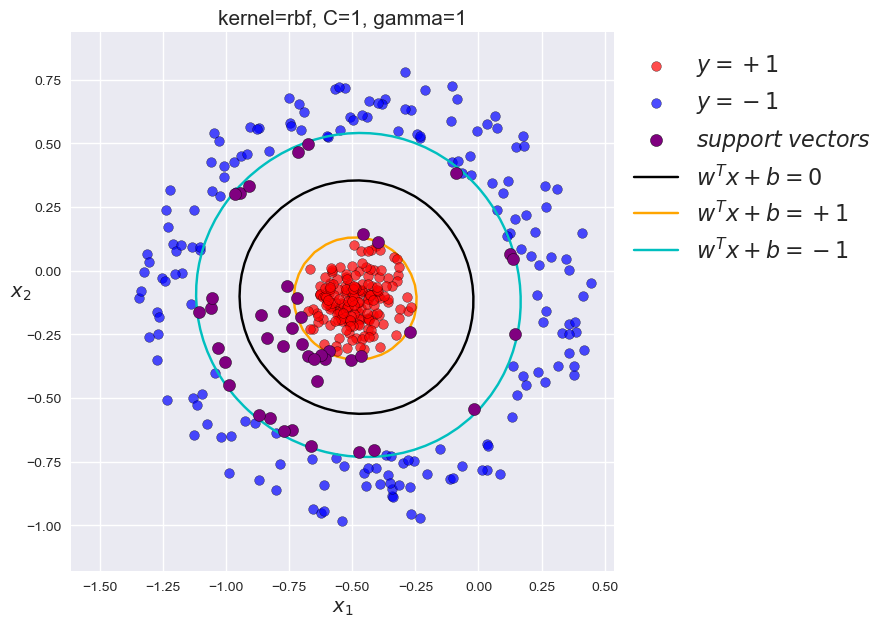

In [41]:
grid, mesh = create_grid(X)

svm = SVC(C=1, gamma=1, kernel='rbf')

svm.fit(X, y)

plot_svm_results(X, y, grid, mesh, svm, 'kernel=rbf, C=1, gamma=1')

It can be seen below that, if we plot the data in a space 1-dimesionally higher, using the distances yielded by the svm's decision function for the z-axis, the rbf kernel has basically mapped the data points onto a 3d cone. The hyperplane and margin separate the tip from the foot of the cone, separating the classes.

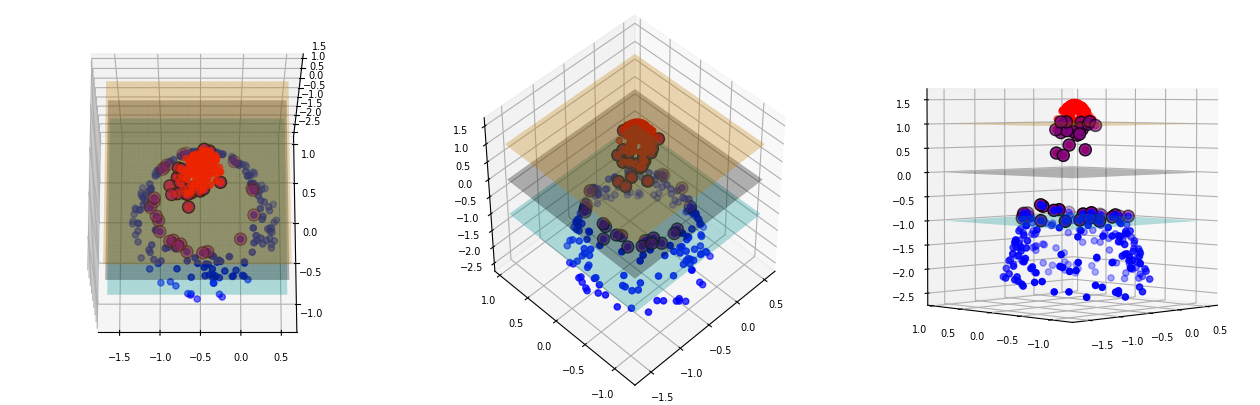

In [42]:
figure(figsize(16, 5))
style.use('default')
z = svm.decision_function(X)
res = 50    
n_dims  = X.shape[1]
min_max = array([get_min_max(X, column=i) for i in range(n_dims)])
mesh    = meshgrid(*(linspace(*mm, res) for mm in min_max))

sv_z = svm.decision_function(svm.support_vectors)

angles = [(70, 270), (45, 225), (3, 225)]
for i in range(3):
    subplot(1, 3, i + 1, projection='3d')
    # Surface
    gca().scatter(*X[y==1].T, z[y==1], c='r')
    gca().scatter(*X[y==-1].T, z[y==-1], c='b')
    gca().plot_surface(*mesh, -ones((50, 50)), color='c', alpha=0.3)
    gca().plot_surface(*mesh, zeros((50, 50)), color='k', alpha=0.3)
    gca().plot_surface(*mesh, ones((50, 50)), color='orange', alpha=0.3)
    gca().scatter(*svm.support_vectors.T, sv_z, c='purple', s=75, edgecolors='k')
    gca().tick_params(axis='both', which='major', labelsize=7)
    gca().view_init(*angles[i])

show()

Lets have a look with some messier data and try some other kernels.

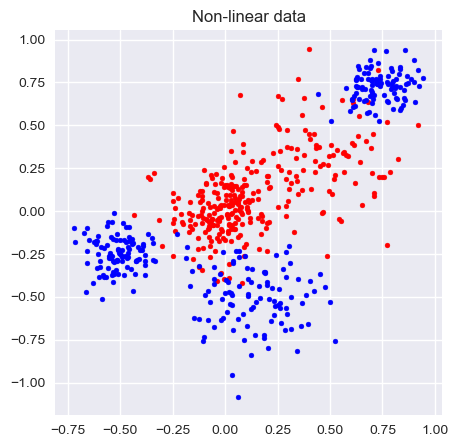

In [43]:
n_samples = 100

seed(0)

mu1    = array([-0.0, -0.0])
sigma1 = array([[0.01, 0.001],
               [0.001, 0.01]])

mu2    = array([0.4, 0.3])
sigma2 = array([[0.05, 0.001],
               [0.001, 0.05]])

mu3    = array([0.0, 0])
sigma3 = array([[0.02, 0.001],
               [0.001, 0.03]])

mu4    = array([0.1, -0.5])
sigma4 = array([[0.03, 0.001],
               [0.001, 0.03]])

mu5    = array([-0.5, -.25])
sigma5 = array([[0.01, 0.001],
               [0.001, 0.01]])

mu6    = array([0.75, 0.75])
sigma6 = array([[0.01, 0.001],
               [0.001, 0.01]])

X = array([*multivariate_normal(mu1, sigma1, n_samples),
           *multivariate_normal(mu2, sigma2, n_samples),
           *multivariate_normal(mu3, sigma3, n_samples),
           *multivariate_normal(mu4, sigma4, n_samples),
           *multivariate_normal(mu5, sigma5, n_samples),
           *multivariate_normal(mu6, sigma6, n_samples)])

y = array([*ones(n_samples * 3), *-ones(n_samples * 3)])

figure(figsize(5, 5))
style.use('seaborn')
scatter(*X[y==1].T, marker='.', c='r')
scatter(*X[y==-1].T, marker='.', c='b')
title('Non-linear data')
show()

In [44]:
def parameter_heatmap(
                      scores, 
                      C_range, 
                      g_range,
                      d_range=None,
                      title_string=' ',
                      **kwargs,
                      ):
    
    '''
    
    Makes a heatmap of optimization landscape for non-linear SVM
    
    Args:
        scores       - scores from GridSearchCV from using C_range and g_range
        C_range      - list/array-like, 1D, range of C values in ascending order
        g_range      - list/array-like, 1D, range of gamma values in ascending order
        d_range      - list/array-like, 1D, range of delta values in ascending order
        title_string - string, the title for the figure
    Returns:
        None
        
        Displays a figure
    
    '''
    scores = scores.reshape(len(C_range), len(g_range))
    
    figure(figsize=(8, 6))
    style.use('default')
    subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    imshow(scores, interpolation='nearest', cmap=cm.gnuplot2)
    xlabel('gamma')
    ylabel('C')
    colorbar()
    xticks(arange(len(g_range)), std_form(g_range), rotation=45)
    yticks(arange(len(C_range)), std_form(C_range))

    title(title_string)
    
    show()

In [45]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

def grid_search(X, t, params={}, clf=SVC()):
    '''
    Performs k_fold cross validation using scikit-learn's GridSearchCV
    
    '''
    
    parameters = [{
                   'kernel': params.get('kernel', ['linear']), 
                   'C': params.get('C', [None]), 
                   'gamma': params.get('gamma', [None]),
                   'delta': params.get('delta', [None])
                  }]
    
    print('Tuning hyper-parameters...')
    
    cv = StratifiedKFold(n_splits=5, shuffle=True)

    grid = GridSearchCV(clf, parameters, cv=cv, n_jobs=-1)
    grid.fit(X, t)
    
    print("The best parameters are %s with a score of %0.2f"
          % (grid.best_params_, grid.best_score_))
    
    mus = grid.cv_results_['mean_test_score']
    stds = grid.cv_results_['std_test_score']
    C = grid.best_params_['C']
    gamma = grid.best_params_['gamma']
    delta = grid.best_params_['delta']
    k = grid.best_params_['kernel']
    
    return C, gamma, delta, k, mus, stds

In [94]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

So we'll do some basic exploration of different kernels and values for hyperparameters

Tuning hyper-parameters...
The best parameters are {'C': 1e-06, 'delta': None, 'gamma': None, 'kernel': 'linear'} with a score of 0.59


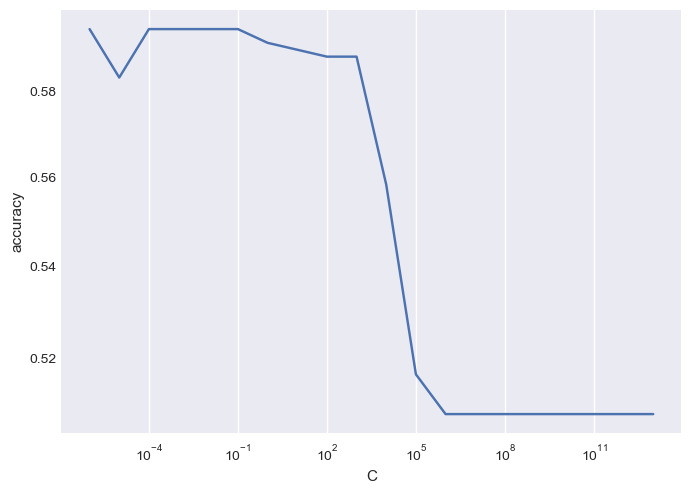

In [52]:
C_range = base_range(1e-6, end=1e14, base=10)

linear_params = grid_search(X, y, params={'C': C_range})

figure()
style.use('seaborn')
loglog(C_range, linear_params[4])
xlabel('C'); ylabel('accuracy')
gca().yaxis.set_minor_formatter(FormatStrFormatter('%.2f'))
show()

It can be seen below that a straight line for a hyperplane doesn't achieve much better then random guess work on this data.

In [55]:
C_range = base_range(1e-2, end=1e3, base=10)

g_range = base_range(1e-2, end=1e3, base=10)

d_range = range(2, 5)

poly_params = grid_search(X, y, params={'C': C_range, 'kernel': ['polynomial'], 'gamma': g_range, 'delta': d_range})

Tuning hyper-parameters...
The best parameters are {'C': 100.0, 'delta': 3, 'gamma': 0.1, 'kernel': 'polynomial'} with a score of 0.95


The polynomial kernel has two hyperparameters to tune. Having delta too high or too low, so that it generates a poor conditioned kernel matrix is quite easy. Furthermore, the time for tuning increases a lot with the additional parameter.
I won't bother plotting the fitness landscape with polynomial because of the extra 'delta' parameter makes it 4-dimensional and complicated to plot.

Tuning hyper-parameters...
The best parameters are {'C': 0.1, 'delta': None, 'gamma': 10.0, 'kernel': 'rbf'} with a score of 0.94


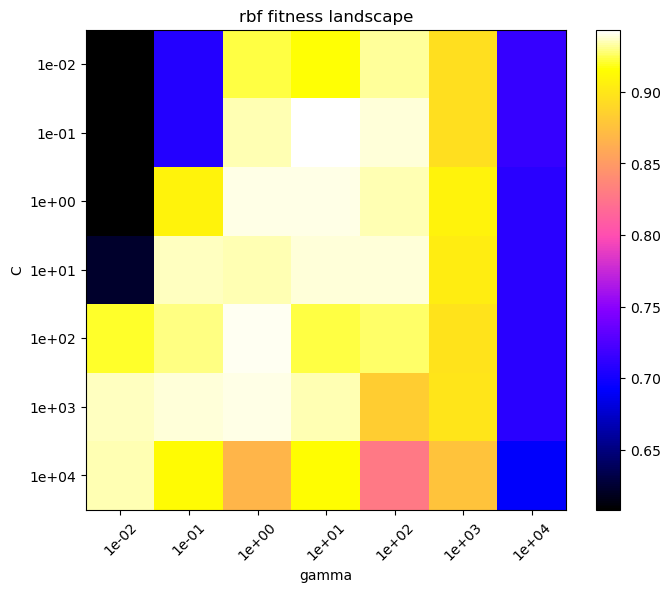

In [56]:
C_range = base_range(1e-2, end=1e3, base=10)

g_range = base_range(1e-2, end=1e3, base=10)

rbf_params = grid_search(X, y, params={'C': C_range, 'kernel': ['rbf'], 'gamma': g_range})

parameter_heatmap(
                  rbf_params[4], 
                  C_range,
                  g_range,
                  title_string='rbf fitness landscape',
                  )

Tuning hyper-parameters...
The best parameters are {'C': 100.0, 'delta': None, 'gamma': 10.0, 'kernel': 'gaussian'} with a score of 0.94


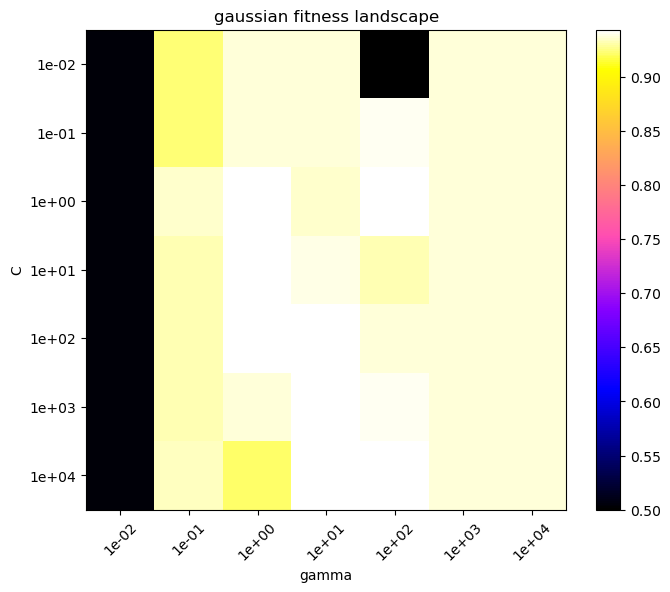

In [57]:
C_range = base_range(1e-2, end=1e3, base=10)

g_range = base_range(1e-2, end=1e3, base=10)

gaussian_params = grid_search(X, y, params={'C': C_range, 'kernel': ['gaussian'], 'gamma': g_range})

parameter_heatmap(
                  gaussian_params[4],
                  C_range,
                  g_range,
                  title_string='gaussian fitness landscape',
                  )

The gaussian kernel is basically a special case of an rbf kernel. 

Lets have a look at the hyperparameter values that achieved the best results for each kernel.

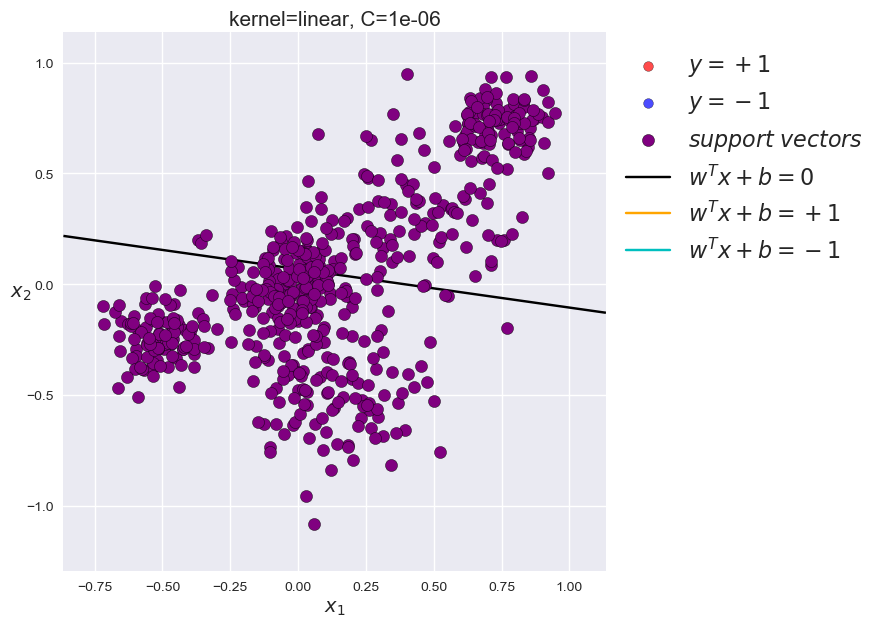

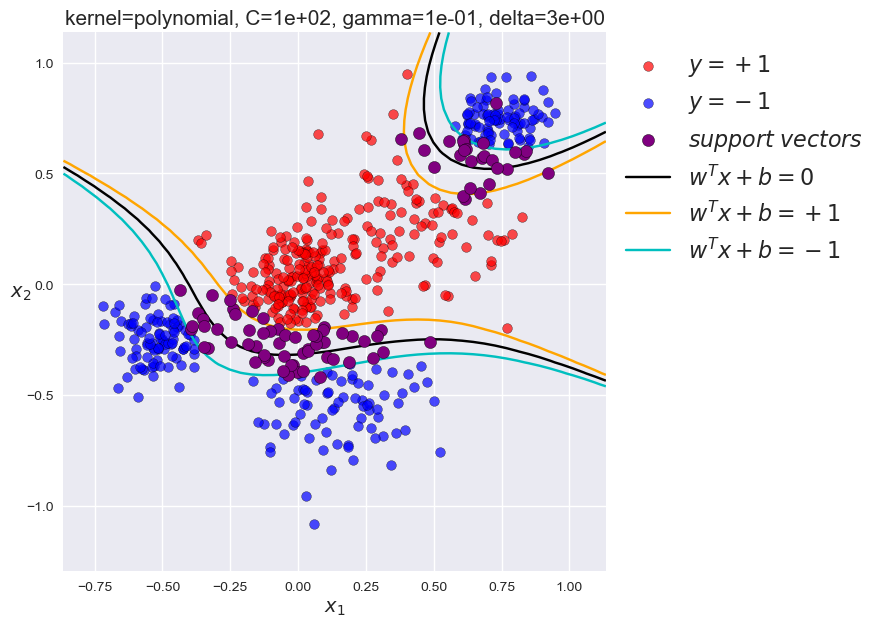

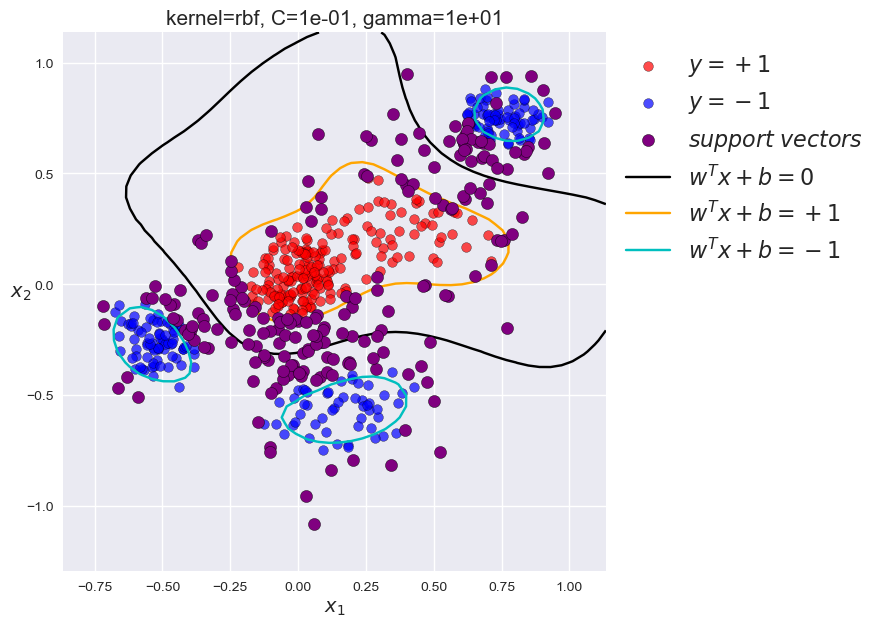

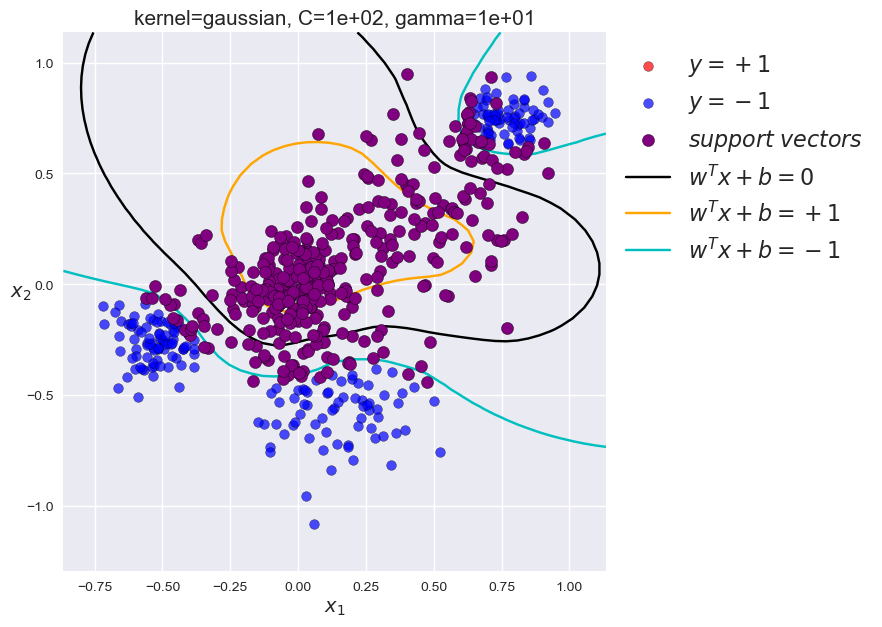

In [58]:
grid, mesh = create_grid(X)

###########################
#         linear          #
###########################

linear_svm = SVC(C=linear_params[0], kernel='linear')

linear_svm.fit(X, y)

plot_svm_results(X, y, grid, mesh, linear_svm, 'kernel=linear, C=%.0e' % linear_params[0])

###########################
#       polynomial        #
###########################

poly_svm = SVC(C=poly_params[0], gamma=poly_params[1], delta=poly_params[2], kernel='polynomial')

poly_svm.fit(X, y)

plot_svm_results(X, y, grid, mesh, poly_svm, 'kernel=polynomial, C=%.0e, gamma=%.0e, delta=%.0e' % poly_params[:3])

###########################
#           rbf           #
###########################

rbf_svm = SVC(C=rbf_params[0], gamma=rbf_params[1], kernel='rbf')

rbf_svm.fit(X, y)

plot_svm_results(X, y, grid, mesh, rbf_svm, 'kernel=rbf, C=%.0e, gamma=%.0e' % rbf_params[:2])

###########################
#        gaussian         #
###########################

gaus_svm = SVC(C=gaussian_params[0], gamma=gaussian_params[1], kernel='gaussian')

gaus_svm.fit(X, y)

plot_svm_results(X, y, grid, mesh, gaus_svm, 'kernel=gaussian, C=%.0e, gamma=%.0e' % gaussian_params[:2])

It can be seen that the non-linear kernels do a much better job in this situation.


Now we will make a grid of subplots and view how C and gamma change the shape of the hyperplane and margin.

In [ ]:
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = hstack([
        linspace(0.0, midpoint, 128, endpoint=False), 
        linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    #register_cmap(cmap=newcmap)

    return newcmap

In [ ]:
def str2(x):
    return ['%d' % i if i >= 1 else '%.1f' % i for i in [x]][0]

In [ ]:
def contour_grid(X, t, kernel):
    # min and max of x1
    x1min, x1max = get_min_max(X)
    # min and max of x2
    x2min, x2max = get_min_max(X, column=1)

    n_rez = 60

    # pseudo test data for plotting hyperplane contours
    X1, X2 = meshgrid(linspace(x1min, x1max, n_rez), linspace(x2min, x2max, n_rez))

    Z = array([[x1, x2] for x1, x2 in zip(ravel(X1), ravel(X2))])

    # shift colormap - basically just for taste
    shifted_cmap = shiftedColorMap(cm.Spectral_r, start=-1.7, midpoint=0.0, stop=1.2)

    C_range = base_range(1e-1, 1e3, 10)
    g_range = base_range(1e-1, 1e2, 10)

    n_cols = len(g_range)
    n_plots = len(C_range) * len(g_range)
    n_rows = math.ceil(n_plots / n_cols)

    figure(figsize=(9 * 1.2, 11 * 1.2))

    style.use('default')

    svm = SVC(kernel=kernel)

    for i, C in enumerate(C_range):

        svm.C = C

        for j, g in enumerate(g_range):

            svm.gamma = g

            svm.fit(X, t)

            distances = svm.decision_function(Z).reshape(X1.shape)
            predictions = sign(distances).reshape(X1.shape)

            subplot(n_rows, n_cols, i * n_cols + (j + 1))

            tick_params(
                        axis='both',    # changes apply to the x-axis
                        which='both',   # both major and minor ticks are affected
                        bottom=False,   # ticks along the bottom edge are off
                        top=False,
                        left=False,      # ticks along the bottom edge are off
                        right=False,     # ticks along the top edge are off
                        labelbottom=False,
                        labelleft=False,
                        )

            # grey background
            pcolormesh(X1, X2, predictions, cmap=cm.Greys_r, edgecolor='#E8E8E8', alpha=0.2, antialiased=True)

            # plot data points
            neg_o = scatter(X[t == -1, 0], X[t == -1, 1], c='b',
                            alpha=1, s=7, edgecolors='w', marker='o', label='$t = -1$')
            pos_o = scatter(X[t == 1, 0], X[t == 1, 1], c='r', 
                            alpha=0.9, s=7, edgecolors='w', marker='o', label='$t = +1$')
            # plot contours
            contour(X1, X2, distances, 7, cmap=shifted_cmap, linewidths=1.2)

            title('$C=%s, γ=%s$' % (str2(C), str2(g)), fontsize=7)


    show()

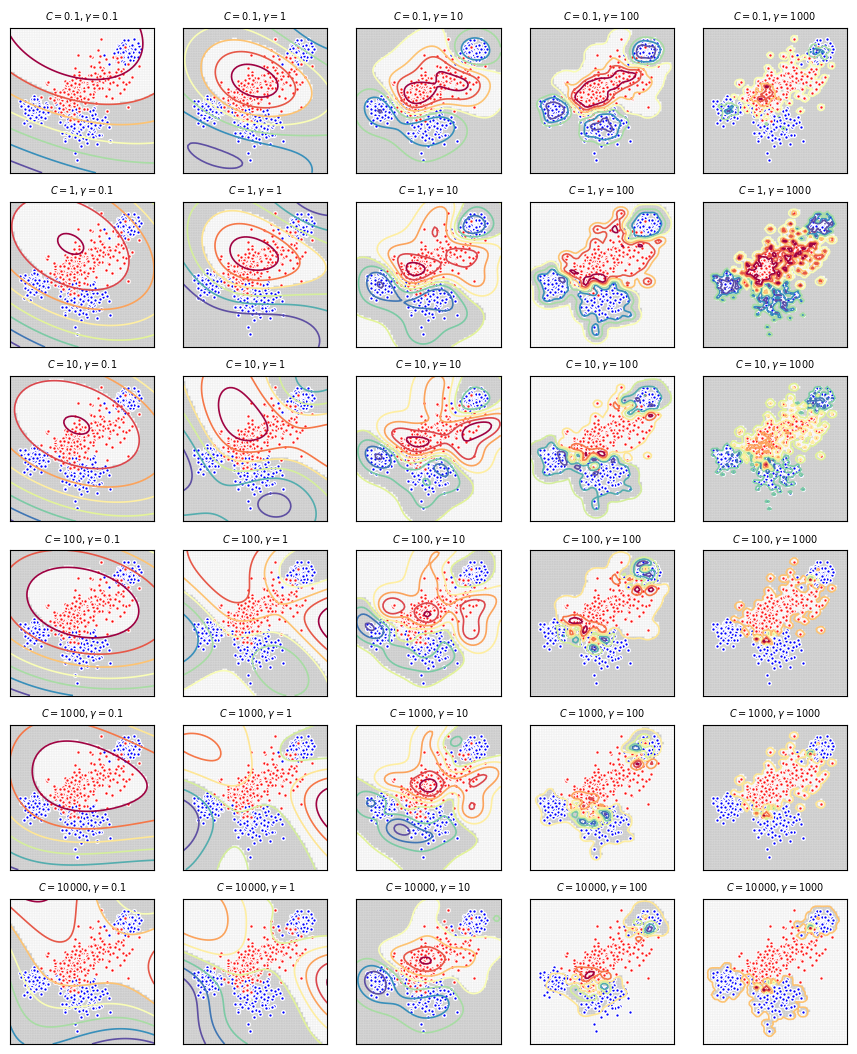

In [62]:
contour_grid(X, y, 'rbf')

The distances output by the SVM give more information about the SVMs performance than its predictions. Furthermore, many of the performance metrics that give the most valuable information about how a model performs require the model to output probabilities. An SVM does not output probabilities, but distances from the hyperplane contain equivalent information. There is a method called `Platt Scaling` that allows us to convert distances into probabilities. This is the same way that sklearn's SVC class outputs probabilities from its predict_proba method. 

Below we will implement a new SVC class with a predict_proba method that uses Platt Scaling.

In [63]:
from sklearn.base import TransformerMixin
from scipy.optimize import fmin_bfgs

class PlattScaler(TransformerMixin):
    """ Perform Platt Scaling.
    Based on Platt 1999
    
    Platt, J.C., 1999. Probabilistic Outputs for Support Vector Machines and Comparisons
    to Regularized Likelihood Methods, Advances in Large Margin Classifiers, 61-74, 
    
    Original code: https://github.com/neal-o-r/platt/blob/master/platt.py
    """

    def __init__(self):
        pass

    def fit(self, f, y):
        """ Fit Platt model.
        This method takes in the classifier outputs and the true labels,
        and fits a scaling model to convert classifier outputs to true
        probabilities. Sticks with Platt's weird notation throughout.

            f: classifier outputs
            y: true labels
        """
        eps = np.finfo(np.float).tiny  # to avoid division by 0 warning

        # Bayes priors
        prior0 = float(np.sum(y <= 0))
        prior1 = y.shape[0] - prior0
        T = np.zeros(y.shape)
        T[y > 0] = (prior1 + 1.) / (prior1 + 2.)
        T[y <= 0] = 1. / (prior0 + 2.)
        T1 = 1. - T

        def objective(theta):
            A, B = theta
            E = np.exp(A * f + B)
            P = 1. / (1. + E)
            l = -(T * np.log(P + eps) + T1 * np.log(1. - P + eps))
            return l.sum()

        def grad(theta):
            A, B = theta
            E = np.exp(A * f + B)
            P = 1. / (1. + E)
            TEP_minus_T1P = P * (T * E - T1)
            dA = np.dot(TEP_minus_T1P, f)
            dB = np.sum(TEP_minus_T1P)
            return np.array([dA, dB])

        AB0 = np.array([0., np.log((prior0 + 1.) / (prior1 + 1.))])
        self.A_, self.B_ = fmin_bfgs(objective, AB0, fprime=grad, disp=False)


    def transform(self, f):
        """
        Given a set of classifer outputs return probs.
        """
        return 1. / (1. + np.exp(self.A_ * f + self.B_))

    def fit_transform(self, f, y):
        self.fit(f, y)
        return self.transform(f)

In [64]:
class SVC(BaseEstimator, ClassifierMixin):
    ''' 
        
        ######################################################################
        # -A soft margin svm classifier capable of using non-linear kernels- #
        ######################################################################
          
    '''

    proba_fit = False
    classes_  = [-1, 1]

    def __init__(
             self,
             C=None,
             gamma=1, 
             delta=1, 
             kernel='linear', 
             threshold=1e-7, 
             dtype=np.float64,
             probability=False,
             solver_params={'solver':'SCS', 'eps': 1e-14, 'acceleration_lookback': 0},
             ):
        '''
        Args:
            C         - float or int, the soft margin penalty
            kernel    - function, takes two array-like objects as input and projects them
                        into a different space, returns a single array-like object
            gamma     - float or int, kernel hyperparameter
            delta     - float or int, kernel hyperparameter (polynomial only)
            threshold - float or int, support vectors have alphas that exceed this value
            dtype     - callable or string, the data type to use, effects precision,
                        i.e. np.float32 or 'float64' 

        '''
        
        self.kernel        = kernel
        self.C             = C
        self.gamma         = gamma
        self.delta         = delta
        self.threshold     = threshold
        self.dtype         = dtype
        self.probability   = probability
        self.solver_params = solver_params
        
    def _init(self):
        
        if self.C:
            self.C = self.dtype(self.C)
            
        if type(self.kernel) == str:
            self.kernel = globals()[self.kernel + '_kernel']

    def fit(self, X, y=None):
        ''' 
        Finds the optimal separating hyperplane by solving the dual constraint quadratic
        optimization problem of maximizing the margin by using cvxopt package
        
        Args:
            X - array-like, shape=[n_samples, n_features], the training data
            y - array-like, shape=[n_samples], training targets/labels
                
        '''
        self._init()
        X = X.astype(self.dtype)
        y = y.astype(self.dtype)
        n_samples, n_features = X.shape
    
        # Compute proto kernel/gram matrix
        K = self.kernel(X, params={'gamma': self.gamma, 'delta': self.delta})

        # Build the variables
        P = np.outer(y, y) * K # kernel/gram matrix
        q = -np.ones(n_samples, dtype=self.dtype) # negative makes it a minimization problem
        A = y.reshape(1, -1)
        b = self.dtype(0.0)
        x = cp.Variable(n_samples) # alphas
        
        # Constraints
        if self.C:  # If soft margin classifier...
            G = np.vstack((-np.eye(n_samples, dtype=self.dtype), np.eye(n_samples, dtype=self.dtype)))
            h = np.hstack((np.zeros(n_samples, dtype=self.dtype), np.ones(n_samples, dtype=self.dtype) * self.C))
        else:       # Hard margin...
            G = np.diag(-np.ones(n_samples, dtype=self.dtype))
            h = np.zeros(n_samples, dtype=self.dtype) # self.dtype(0.0) #
            
        objective   = cp.Minimize(0.5 * cp.quad_form(x, P) + q.T @ x)
        constraints = [G @ x <= h, 
                       A @ x == b]

        problem     = cp.Problem(objective, constraints)
        problem.solve(**self.solver_params)

        self.alphas = x.value

        # Support vectors have non zero lagrange multipliers
        mask = self.alphas > self.threshold # threshold otherwise we end up with everything being a support vector
        self.alphas = self.alphas[mask]
        self.support_vectors = X[mask]
        self.support_vector_labels = y[mask]

        # Calculate bias:
        # .. math::
        # b = rac{1}{N_S}\sum\limits_{v∈S} [α_u y_u k(x_u , x_v )]

        self.b   = self.dtype(0.0)
        self.idx = np.arange(len(X))[mask]
        n_alpha  = len(self.alphas)

        for i in range(n_alpha):
            self.b += self.support_vector_labels[i]
            self.b -= np.sum(self.alphas * self.support_vector_labels * K[self.idx[i], mask])
        self.b /= n_alpha
        
        if self.probability:
            self.plattscaler = PlattScaler()
            distances = self.decision_function(X)
            self.plattscaler.fit(distances, y)
            self.proba_fit = True

        return self

    def decision_function(self, X):
        
        distances = np.zeros(len(X), dtype=self.dtype)
        for i in range(len(X)):
            for a, xn, xn_y in zip(
                                   self.alphas,
                                   self.support_vectors,
                                   self.support_vector_labels, 
                                   ):
                
                distances[i] += a * xn_y * self.kernel(X[i], xn, params={'gamma': self.gamma, 'delta': self.delta})
        distances += self.b
        return distances

    def predict_proba(self, X):
        if not self.proba_fit:
            raise Exception("SVC must be initialized with 'probability' keyword argument set to True \
            before calling fit method in order to use Platt Scaling and produce probabilistic outputs")
        distances = self.decision_function(X)
        probabilities = self.plattscaler.transform(distances)
        return probabilities
    
    def predict(self, X):
        '''
        Classifies the samples in X as either 1 or -1 depending on which side of the 
        hyperplane they lie
        
        Args:
            X                - array-like, shape=[n_samples, n_features], the training data
        Returns:
            predictions      - array-like, shape=[n_samples], the classifications

        '''
        return np.sign(self.decision_function(X))

Again the new SVC class has been saved as a .py file and is ready for import

In [41]:
from svm2 import SVC

In [42]:
from sklearn.metrics import log_loss, make_scorer, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
#from sklearn.model_selection import KFold
#scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)

We're going to mess around with calibration. It will be calibration will be more obvious with more data so we'll generate more samples.

With the predict_proba method we can do a simple mock calibration to see how good the predicted probabilities are.

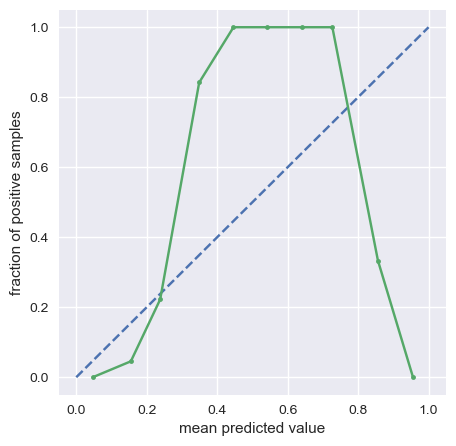

In [90]:
clf = SVC(probability=True, C=1, gamma=1)
clf.fit(X_train, y_train)
probabilities = clf.predict_proba(X_test)[:, 1]
# reliability diagram
fop, mpv = calibration_curve(y_test, probabilities, n_bins=10, normalize=True)
figure(figsize(5, 5))
# plot perfectly calibrated
plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plot(mpv, fop, marker='.')
ylabel('fraction of positive samples')
xlabel('mean predicted value')
show()

This is a reliability diagram, ideally we want it to match the dotted blue line.

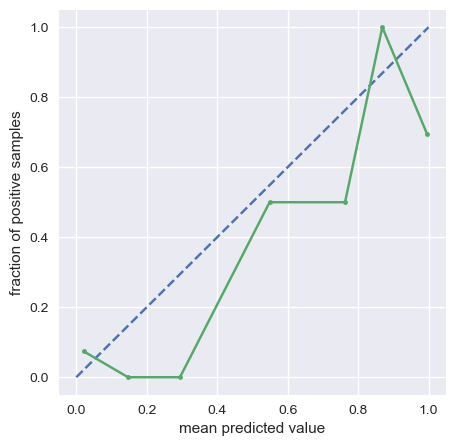

In [91]:
clf = CalibratedClassifierCV(SVC(probability=True, C=1, gamma=1), method='isotonic', cv=5)
clf.fit(X_train, y_train)
# predict probabilities
probabilities = clf.predict_proba(X_test)[:, 1]

# reliability diagram
fop, mpv = calibration_curve(y_test, probabilities, n_bins=10, normalize=True)
figure(figsize(5, 5))
# plot perfectly calibrated
plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
plot(mpv, fop, marker='.')
ylabel('fraction of positive samples')
xlabel('mean predicted value')
show()

In [96]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

def grid_search(X, y, scorer=None, params={}, clf=SVC()):
    '''
    Performs k_fold cross validation using scikit-learn's GridSearchCV
    
    '''
    
#     parameters = [{
#                    'kernel': params.get('kernel', ['linear']), 
#                    'C': params.get('C', [None]), 
#                    'gamma': params.get('gamma', [None]),
#                    'delta': params.get('delta', [None])
#                   }]
    
    print('Tuning hyper-parameters...')
    
    cv = StratifiedKFold(n_splits=5, shuffle=True)

    clf = GridSearchCV(clf,
                        param_grid=params,
                        scoring=scorer,
                        cv=cv, 
                        n_jobs=-1)
    clf.fit(X, y)
    
    print("The best parameters are %s with a score of %0.2f"
          % (clf.best_params_, clf.best_score_))
    
    mus = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    
    C = clf.best_params_['base_estimator__C']
    gamma = clf.best_params_['base_estimator__gamma']
    k = clf.best_params_['base_estimator__kernel']
    
    return C, gamma, k, mus, stds

In [97]:
C_range = base_range(1e-2, end=1e3, base=10)

g_range = base_range(1e-2, end=1e3, base=10)

params = dict(
              base_estimator__C=C_range, 
              base_estimator__kernel=['rbf'], 
              base_estimator__gamma=g_range,
              method=['isotonic']
              )

clf = CalibratedClassifierCV(base_estimator=SVC(probability=True), cv=5)

rbf_params = grid_search(X, y, clf=clf, params=params, scorer=scorer)

Tuning hyper-parameters...
The best parameters are {'base_estimator__C': 0.1, 'base_estimator__gamma': 10.0, 'base_estimator__kernel': 'rbf', 'method': 'isotonic'} with a score of 0.99


But what about when there is more than 2 classes?!?!

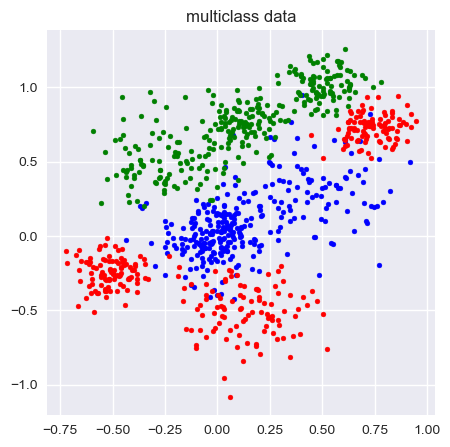

In [98]:
n_samples = 100

seed(0)

mu1    = array([-0.0, -0.0])
sigma1 = array([[0.01, 0.001],
               [0.001, 0.01]])
mu2    = array([0.4, 0.3])
sigma2 = array([[0.05, 0.001],
               [0.001, 0.05]])
mu3    = array([0.0, 0])
sigma3 = array([[0.02, 0.001],
               [0.001, 0.03]])
mu4    = array([0.1, -0.5])
sigma4 = array([[0.03, 0.001],
               [0.001, 0.03]])
mu5    = array([-0.5, -.25])
sigma5 = array([[0.01, 0.001],
               [0.001, 0.01]])
mu6    = array([0.75, 0.75])
sigma6 = array([[0.01, 0.001],
               [0.001, 0.01]])
mu7    = array([-0.25, 0.5])
sigma7 = array([[0.03, 0.001],
               [0.001, 0.03]])
mu8    = array([0.125, .75])
sigma8 = array([[0.01, 0.001],
               [0.001, 0.01]])
mu9    = array([0.5, 1.0])
sigma9 = array([[0.01, 0.001],
               [0.001, 0.01]])

X = array([*multivariate_normal(mu1, sigma1, n_samples),
           *multivariate_normal(mu2, sigma2, n_samples),
           *multivariate_normal(mu3, sigma3, n_samples),
           *multivariate_normal(mu4, sigma4, n_samples),
           *multivariate_normal(mu5, sigma5, n_samples),
           *multivariate_normal(mu6, sigma6, n_samples),
           *multivariate_normal(mu7, sigma4, n_samples),
           *multivariate_normal(mu8, sigma5, n_samples),
           *multivariate_normal(mu9, sigma6, n_samples),
           ])

y = array([*zeros(n_samples * 3), *ones(n_samples * 3), *full(n_samples * 3, 2)])

figure(figsize(5, 5))
style.use('seaborn')
scatter(*X[y==0].T, marker='.', c='b')
scatter(*X[y==1].T, marker='.', c='r')
scatter(*X[y==2].T, marker='.', c='g')
title('multiclass data')
show()

# Multi-class classification
The SVM naturally classifies data into two classes, but many problems have $K> 2$ classes.  One strategy for multi-class classification is to construct a classifiers for every pair of classes (there are $K(K-1) / 2$ of these).  Then to make a prediction about a new observation $x'$, each of the classifiers is used to predict the class of $x'$ and it is assigned to the class that gets the largest number of votes. 

Below I have coded a multiclass svm classifier that fits an ensemble of svms with a single svm for each pair of classes. A new data point is classified based on the most popular classification from the ensemble i.e. the modal/most popular classification.

In [92]:
import numpy as np
from scipy.stats import mode
from sklearn.model_selection import GridSearchCV, StratifiedKFold

class MultiClassSVM:
    '''
            #########################################################
            #    An implementation of SVM for multiclass problems   #
            #########################################################
    '''
    
    def __init__(
                 self,
                 classifier=SVC,
                 param_grid={},
                 random_state=117,
                 clf_kwargs={},
                 ):
        '''
        Args:
            n_estimators - int, number of weak classifier instance in the ensemble
            classifier   - class with fit and predict method
            attr         - dict, string: value, attributes of the weak learners
            random_state - hashable, something to seed the random generator
            
        '''
        np.random.seed(random_state)
        self.classifier = classifier
        self.param_grid = param_grid
        #self.mode = __import__('scipy').stats.mode
        self.clf_kwargs = clf_kwargs
    
    def fit(self, X, y=None):
        
        '''
        Fits an svm for each pair of classes in the dataset
        
        Args:
            X - array-like, sample training data, shape=[n_samples, n_features]
            y - array-like, target labels, shape=[n_samples]
        '''

        self.ensemble = {}
        self.n_classes = len(np.unique(y))
        self.n_estimators = int(self.n_classes * (self.n_classes - 1) / 2)

        for i in range(self.n_classes - 1):
            for j in range(i + 1, self.n_classes):
            
                # get indices of classes
                idx_i = y==i
                idx_j = y==j
                
                # make new X and y with selected classes
                y_ = np.append(y[idx_i], y[idx_j])
                X_ = np.vstack((X[idx_i], X[idx_j]))

                # set labels to -1 and 1
                y_ = np.array([1 if k == i else -1 for k in y_])
                
                # shuffle
                idx = np.random.permutation(range(len(y_)))
                y_ = y_[idx]                  
                X_ = X_[idx]  

                # get best parameters

                cv = StratifiedKFold(n_splits=5, shuffle=True)

                grid = GridSearchCV(self.classifier(**self.clf_kwargs),
                                    param_grid=self.param_grid,
                                    #scoring=scorer,
                                    cv=cv, 
                                    n_jobs=-1)
                grid.fit(X_, y_)

                C = grid.best_params_['C']
                gamma = grid.best_params_['gamma']
                kernel = grid.best_params_['kernel']
                
#                 # create classifier and fit
#                 clf = self.classifier(C=C, gamma=gamma, kernel=kernel, **self.clf_kwargs)
#                 clf.fit(X_, y_)
                
                # store classifier and parameters
                self.ensemble[(i, j)] = {
                                         'clf': grid.best_estimator_, 
                                         'C': C, 
                                         'gamma': gamma, 
                                         'kernel': kernel,
                                         }
                
        return self

    def predict(self, X):
        '''
        Predict the class of each sample in X
    
        Args:
            X           - array-like, sample training data, shape[n_samples, n_features]
        
        Returns:
            predictions - array-like, predicted labels, shape[n_samples]

        '''
        n_samples = X.__len__()                        
        predictions = np.zeros([self.n_estimators, n_samples])
        i = 0

        for label, clf in self.ensemble.items():
            predictions[i] = [label[0] if j == 1 else label[1] for j in clf['clf'].predict(X)]
            i += 1

        return mode(predictions)[0][0].astype(int)

Use your classifier to classify the famous "iris" data, which has two classes.  You can load and visualise it as follows. 



You should be able to see that the internals of the classifier use sklearn's GridSearchCV function. This means I have again made a .py file with the multiclass classifier which needs to be imported as below.

In [99]:
from multiclass_svm import MultiClassSVM

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [48]:
C_range = base_range(1e0, 1e5, 10)
g_range = base_range(1e0, 1e5, 10)

parameters = {
              'kernel': ['linear', 'rbf', 'gaussian'], 
              'C': C_range, 
              'gamma': g_range,
              }

mcsvm = MultiClassSVM(param_grid=parameters)

mcsvm.fit(X_train, y_train)

predictions = mcsvm.predict(X_test)

In [51]:
print(mean(predictions == y_test))

0.9111111111111111


90+% seems pretty acceptable and probably has potential to be improved upon.

Below we'll visualize the 'decision function'.

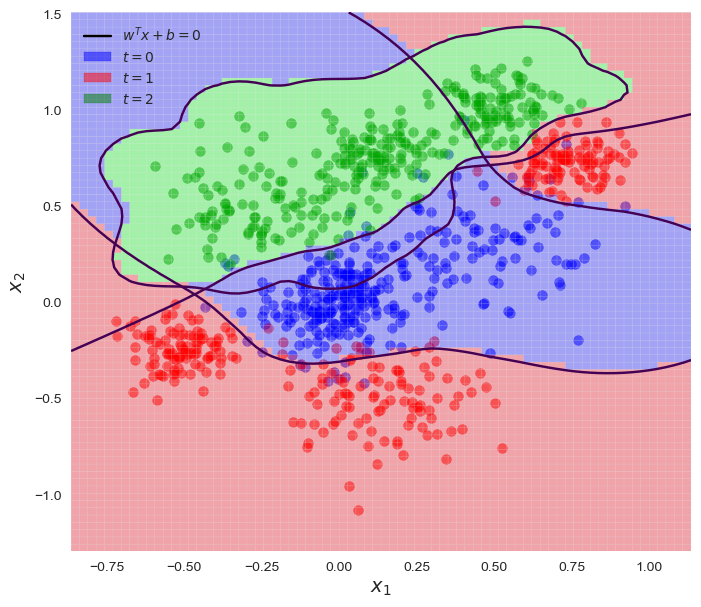

In [82]:
# min and max of x1
x1min, x1max = get_min_max(X)
# min and max of x2
x2min, x2max = get_min_max(X, column=1)

# pseudo test data for plotting hyperplane contours
X1, X2 = meshgrid(linspace(x1min, x1max, 75), linspace(x2min, x2max, 75))
Z = array([[x1, x2] for x1, x2 in zip(ravel(X1), ravel(X2))])

figure(figsize=(8, 7))
style.use('seaborn')

for label, clf in mcsvm.ensemble.items():
    p = clf['clf'].decision_function(Z).reshape(X1.shape)
    contour(X1, X2, p, [0.0],  cmap='viridis')
    
cols = ['b', 'r', 'g']

classes = unique(y).astype(int)

predictions = mcsvm.predict(Z)
    
for c in classes:
    scatter(X[y == c, 0], X[y == c, 1], c=cols[c], s=30, alpha=0.5, marker='o')

xlabel('$x_1$', fontsize=14); ylabel('$x_2$', fontsize=14)
hyp_l = mlines.Line2D([], [], color='k', linestyle='-', label='$w^Tx + b = 0$')
blu_o = mpatches.Patch(color='b', label='$y = %d$' % classes[0], alpha=0.5)
red_o = mpatches.Patch(color='r', label='$y = %d$' % classes[1], alpha=0.5)
gre_o = mpatches.Patch(color='g', label='$y = %d$' % classes[2], alpha=0.5)
pcolormesh(X1, X2, predictions.reshape(X1.shape), cmap=cm.brg, edgecolor='#E8E8E8', alpha=0.3, antialiased=True)
legend(handles=[hyp_l, blu_o, red_o, gre_o])

show()

We have seen some examples of how an SVM works and what each of its hyperparameters does.

The main weakness of the SVM is that it does not work well on very large datasets. This is because it requires every data point to be in memory at the same time and/or the number of distance calculations required increases hugely with the size of the dataset. Some of these can be alleviated with other optimization algorithms which, for example, may not explicitly calculate the entire kernel/gram matrix. Another weakness is of course that it is only really good for binary classification problems or separating two groups. Although we can create a multiclass/ensemble version, it is apparent that this is quite slow and computationally inefficient and that there are probably better classifiers available for multiclass problems.